Work analysis script
-------------------


John Chodera, Dom Rufa, Hannah Bruce Macdonald

### FAH todo
* Figure out CPU/GPU force discrepancy
* prune outliers
* Generate plots labeling GENS
* Draw the plots so that I->J and J->I are neighbours

In [1]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from freeenergyframework import plotting


#Move this up
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [2]:
with bz2.BZ2File('fah_temp/work.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [51]:
# with open('/Users/brucemah/Downloads/work.pkl', 'rb') as infile:
#     work = pickle.load(infile)
    
# Plot by RUN
projects = {
    'complex' : 'PROJ13404',
    'solvent' : 'PROJ13405'}
GEN = 'GEN0'

n_boots = 1000 # change in a bit

phase = 'complex'
PROJ = projects[phase]
run_index = 0
NRUNS = len(work[PROJ])

In [34]:
### TODO - unhardcode this

details_throm = np.load('data/Thrombin_results.npy',allow_pickle=True).flatten()[0]
details_jnk = np.load('data/Jnk1_results.npy',allow_pickle=True).flatten()[0]

In [35]:
details = {}

details.update(details_throm)
details.update(details_jnk)

In [50]:
print(details['RUN0'])

{'start_ligand': 0, 'end_ligand': 1, 'protein_pdb': 'Thrombin_protein.pdb', 'experimental': -0.21000000000000085, 'complex_fes': array([1.15255027, 1.34034221, 1.07497749, 1.11177265, 1.13830929,
       1.10462347, 1.22416581, 1.23462018, 1.09550522, 1.11884483]), 'solvent_fes': array([1.27246306, 1.13833202, 1.21037005, 1.10554025, 1.21862924,
       1.23246111, 1.36232931, 1.29349504, 1.27077109, 1.16905534]), 'calculated': 0.06777350631021606, 'calculated_err': 0.1068986467048521}


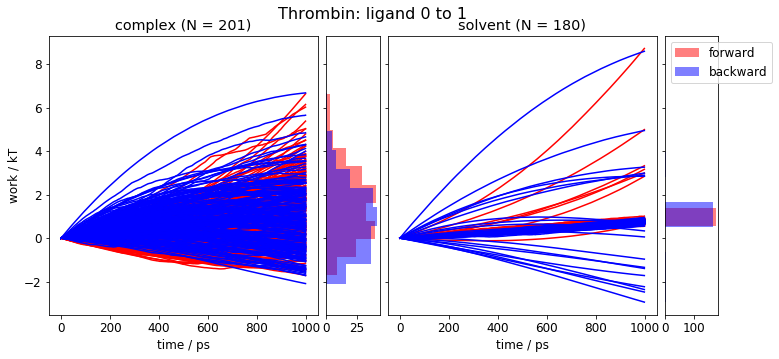

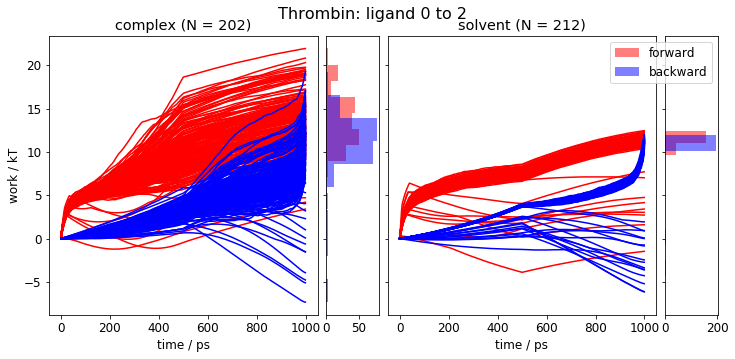

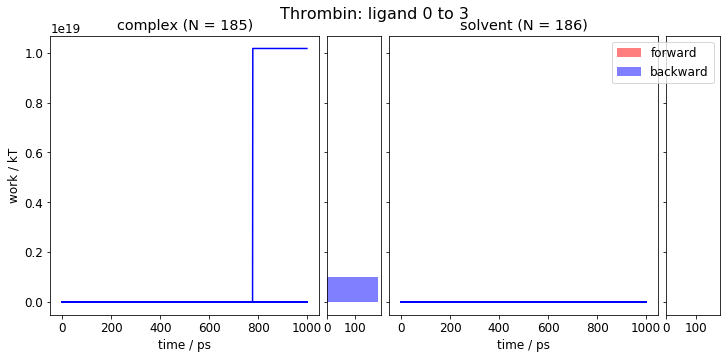

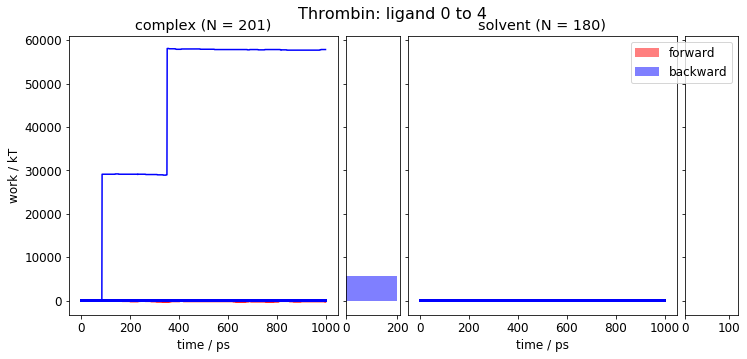

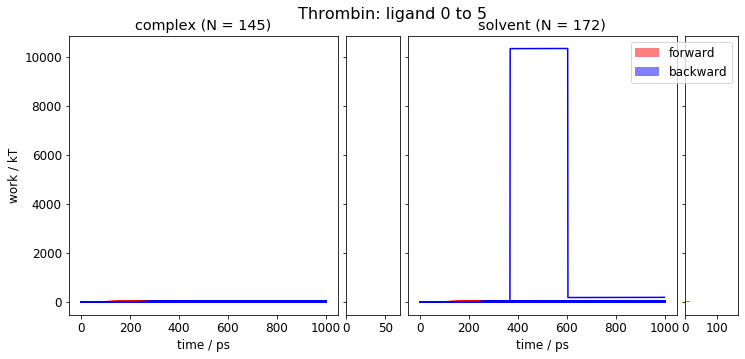

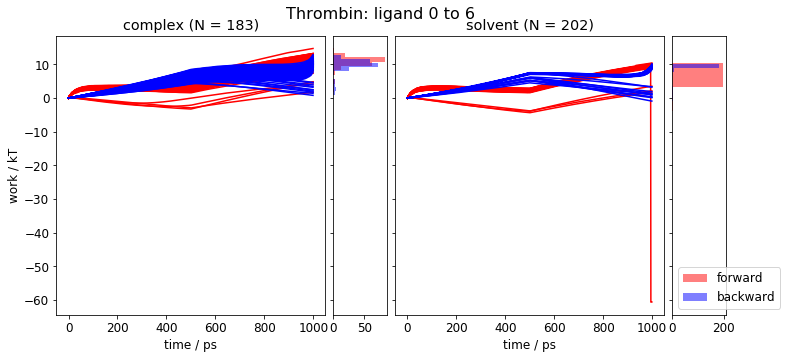

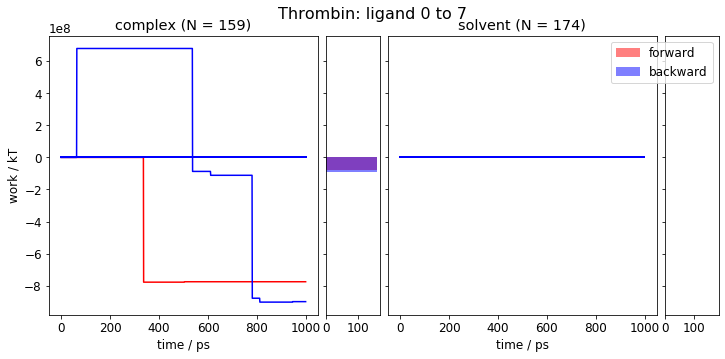

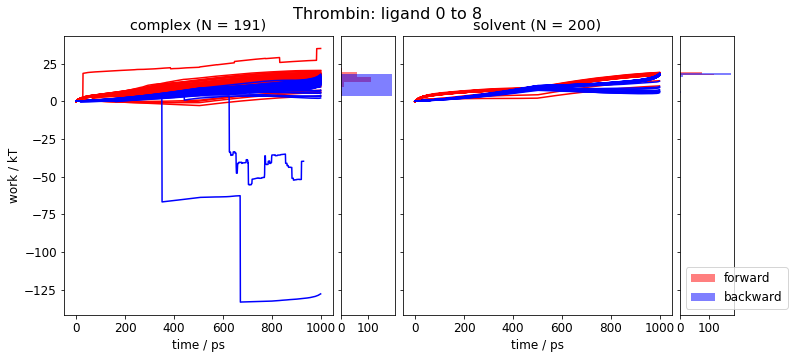

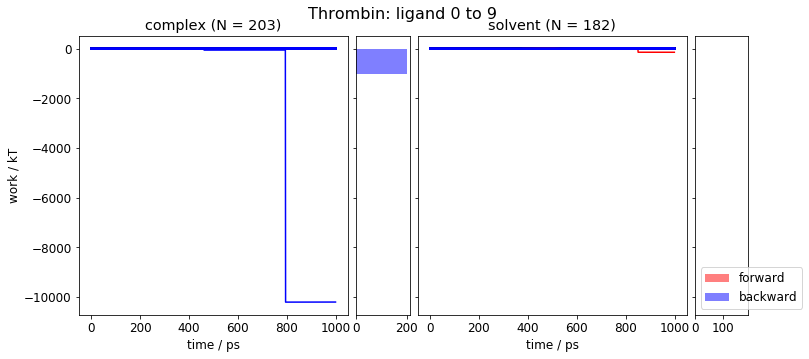

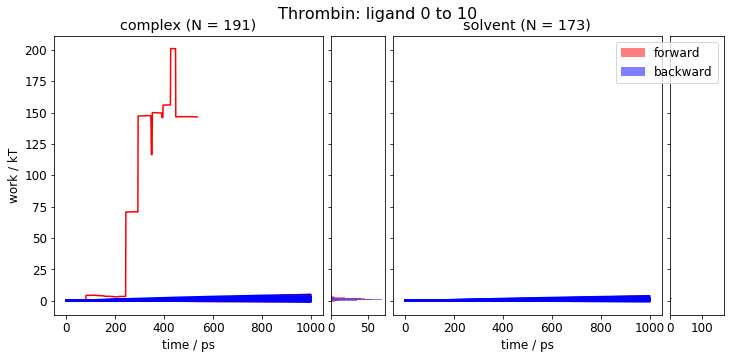

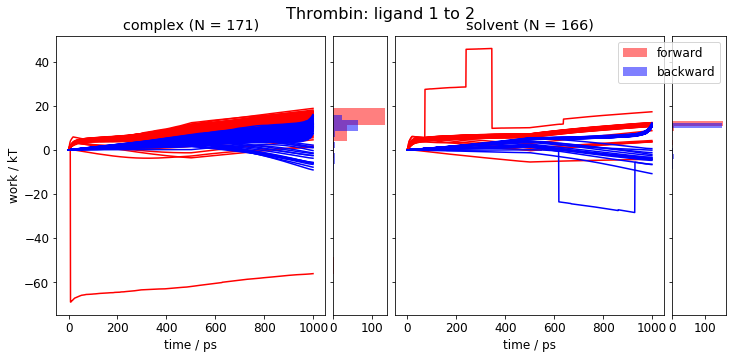

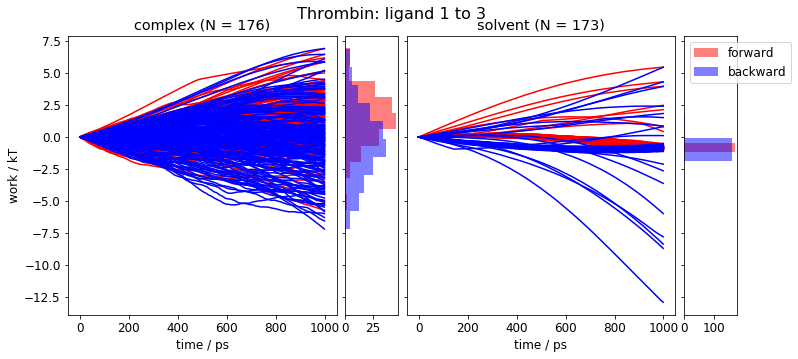

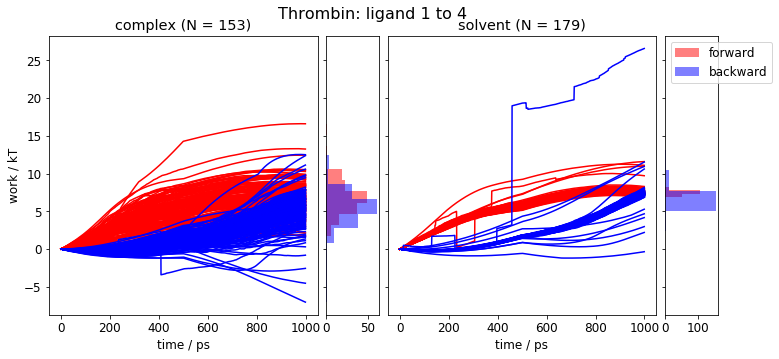

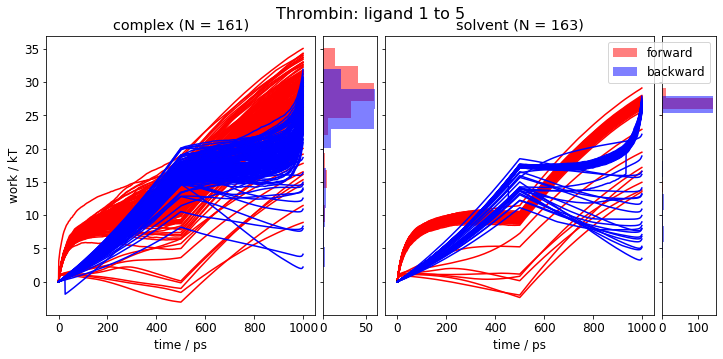

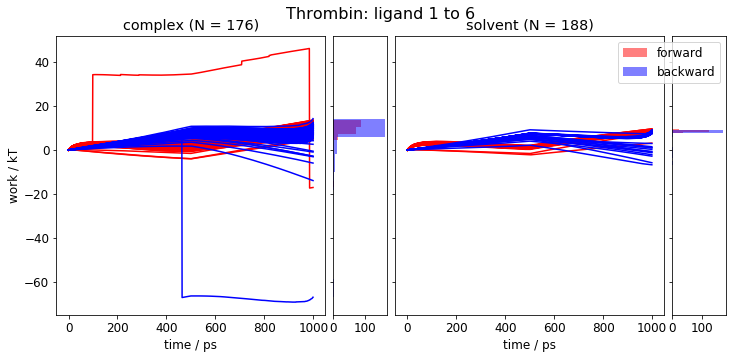

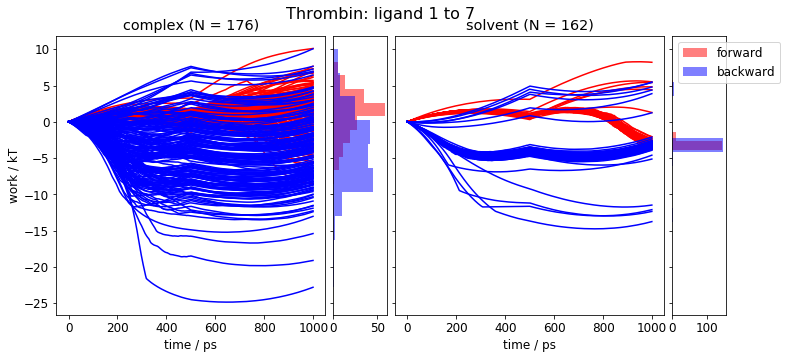

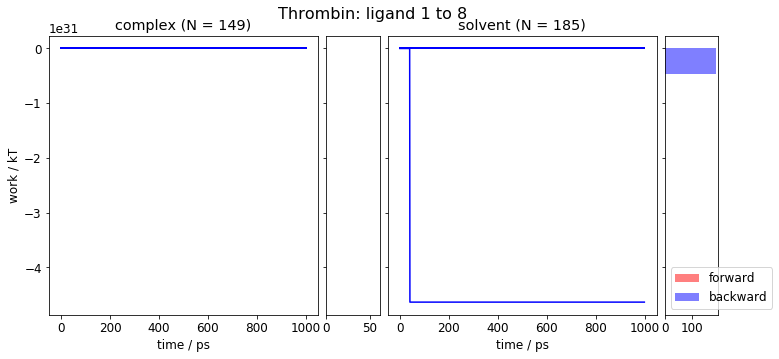

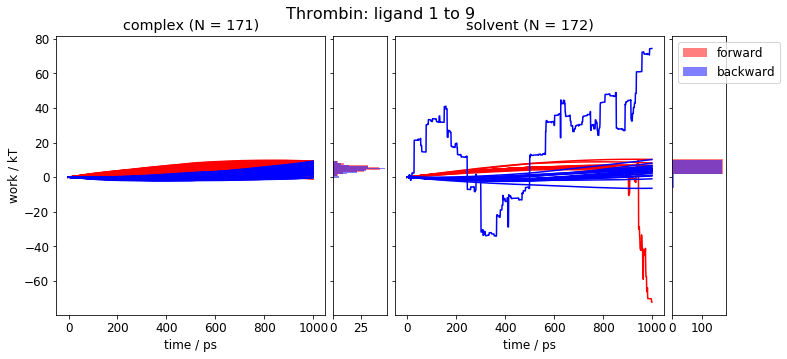

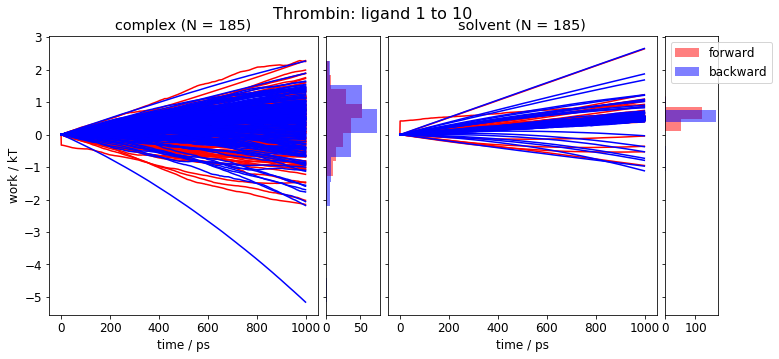

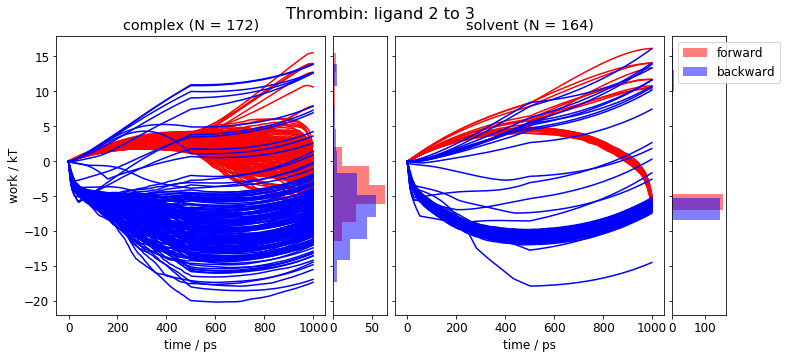

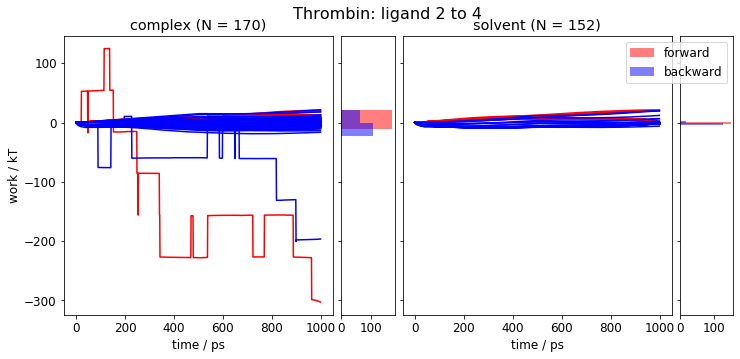

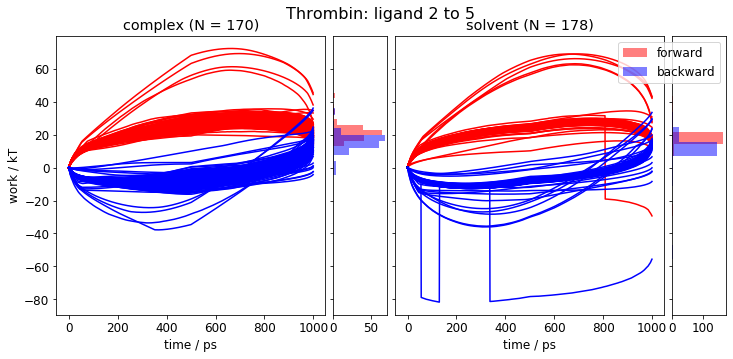

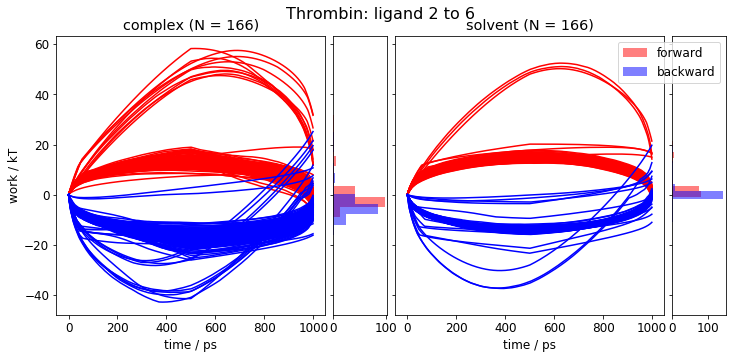

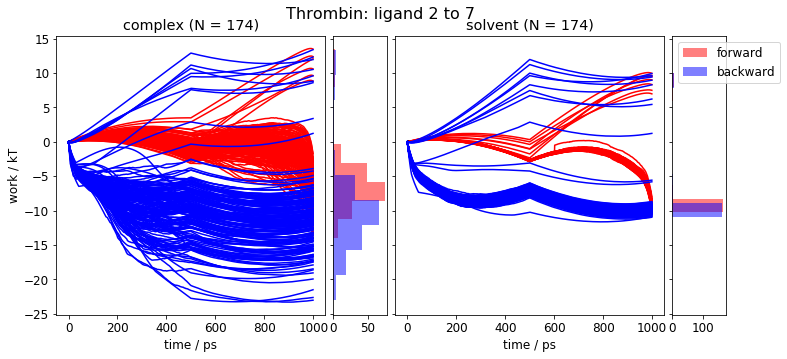

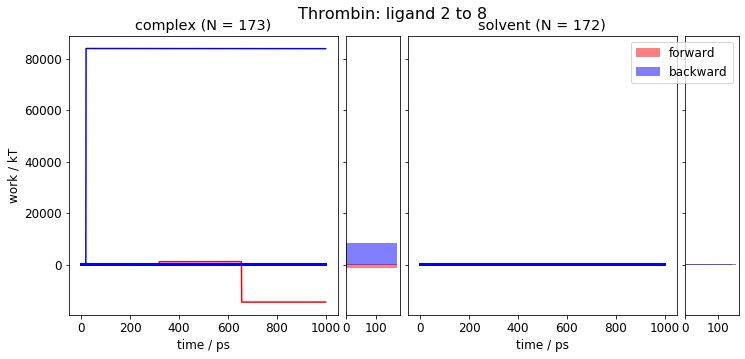

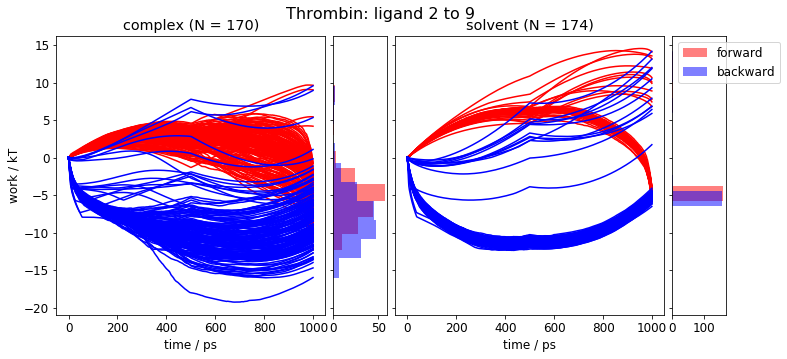

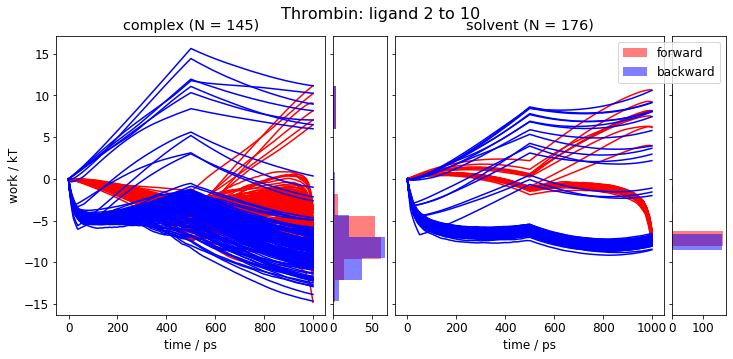

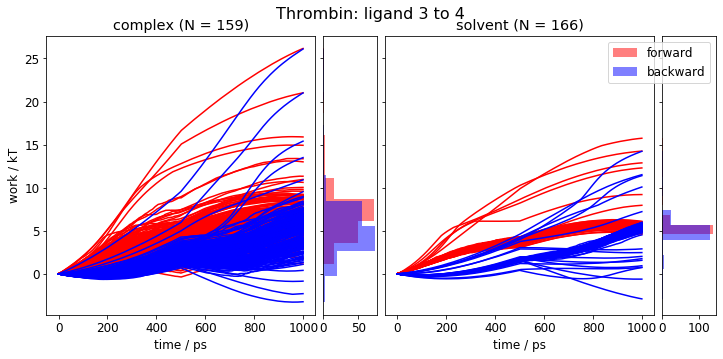

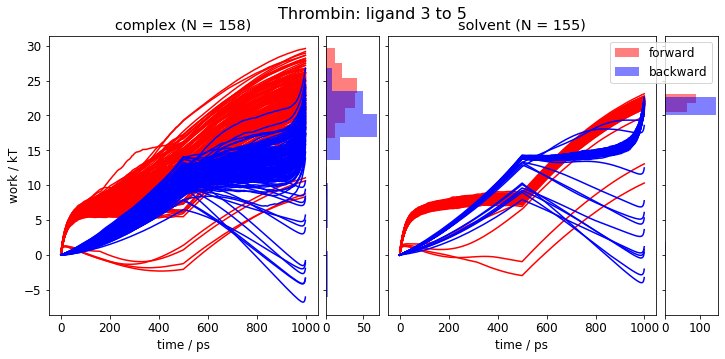

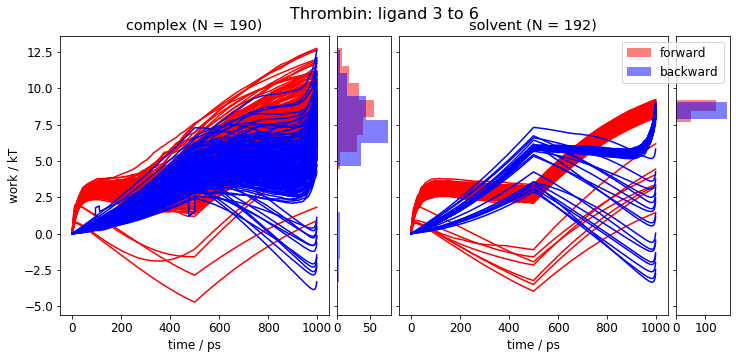

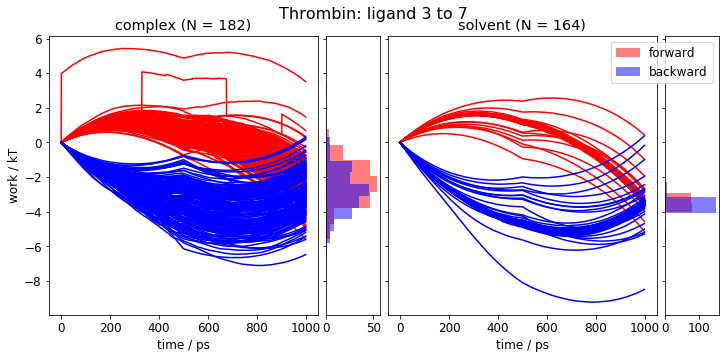

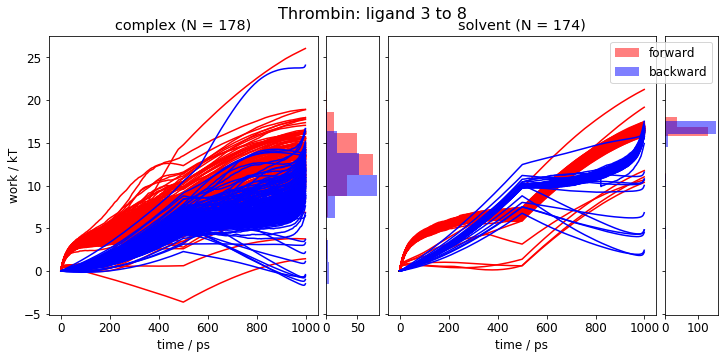

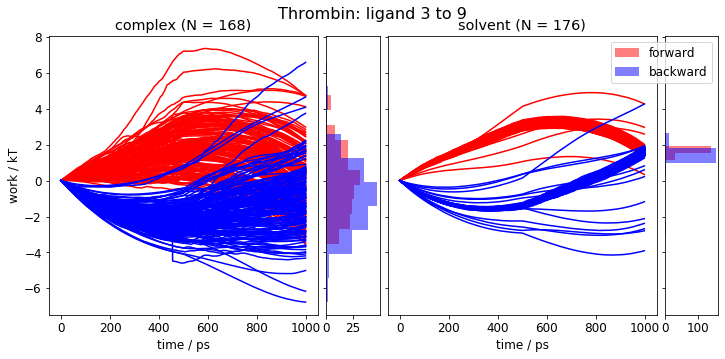

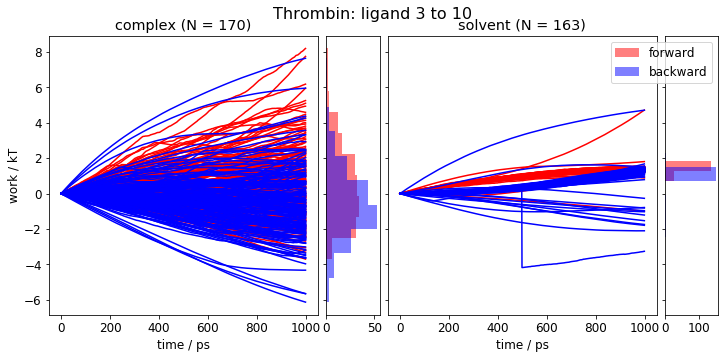

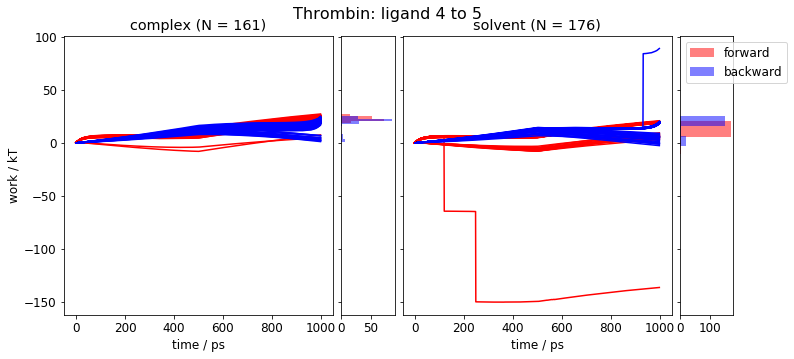

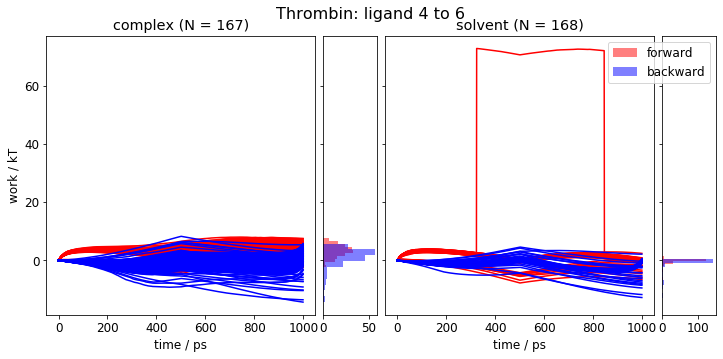

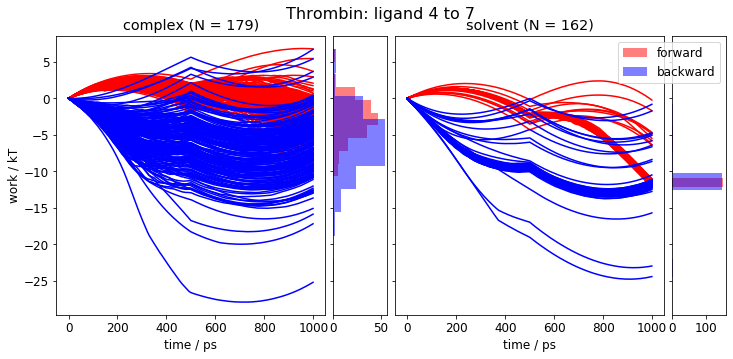

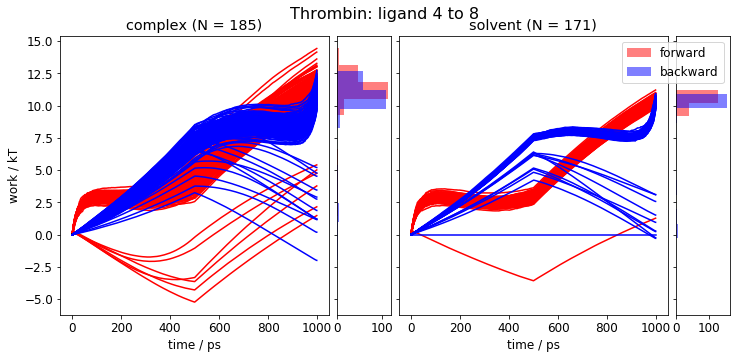

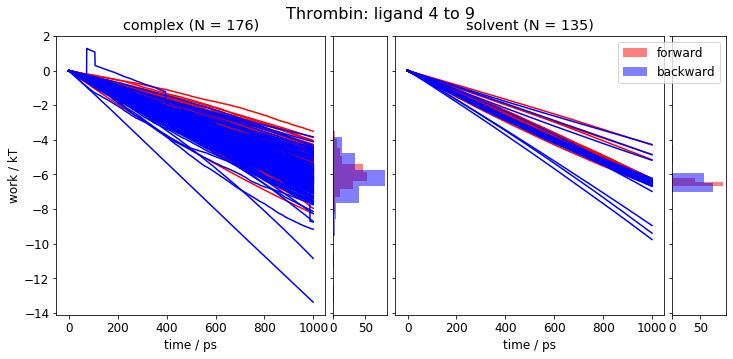

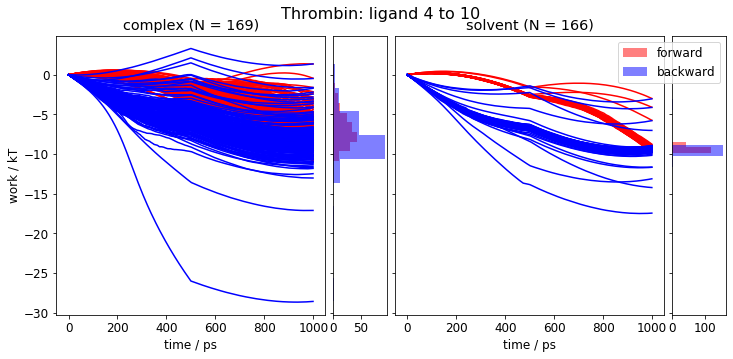

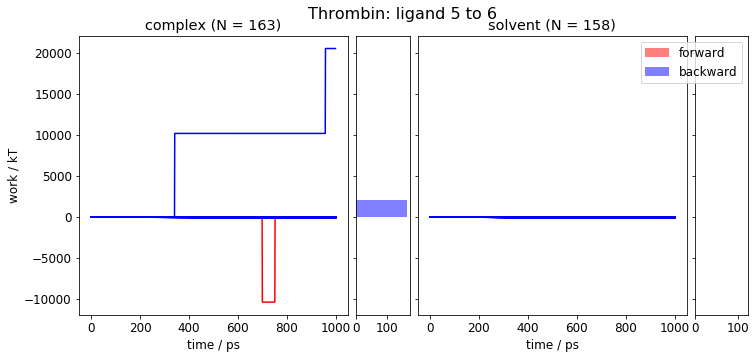

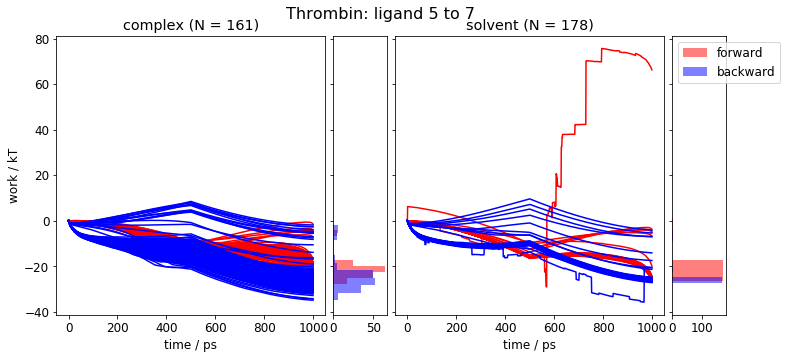

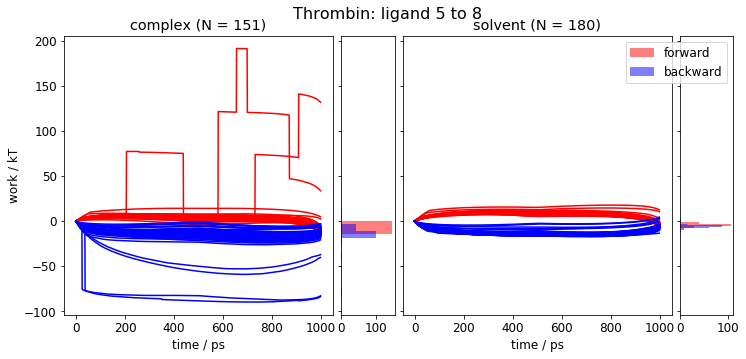

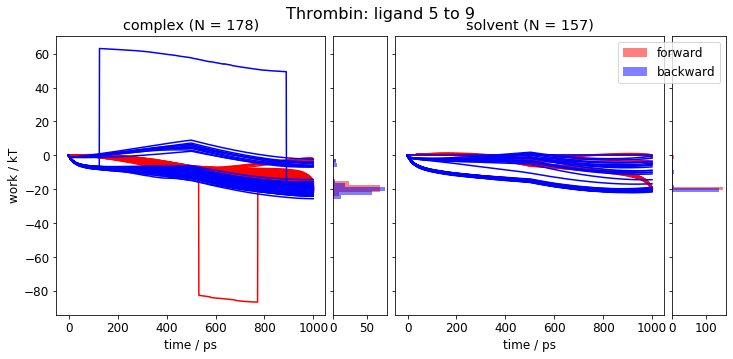

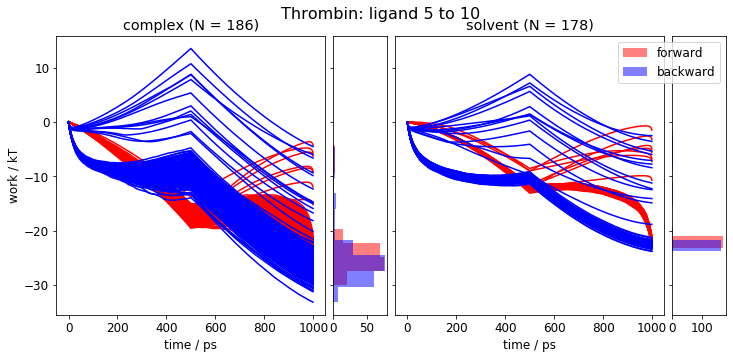

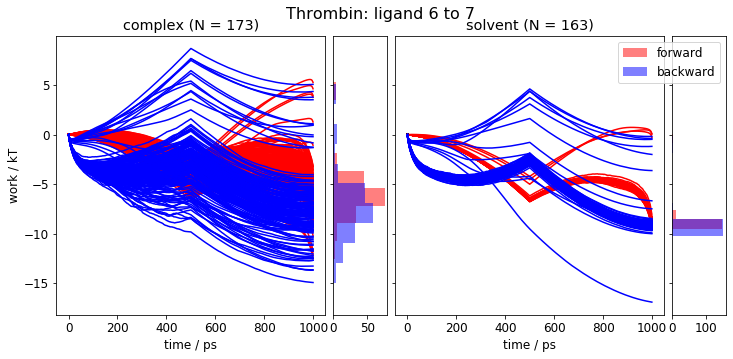

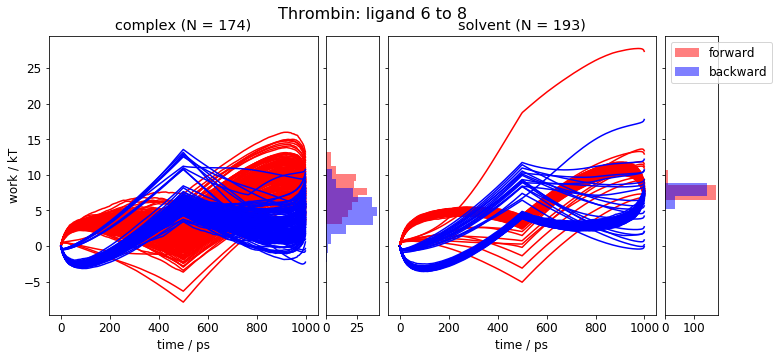

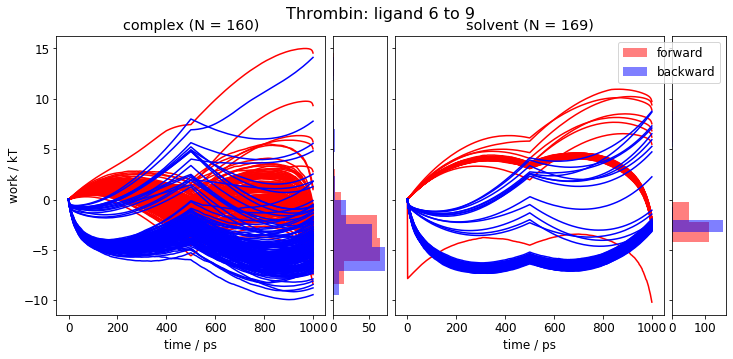

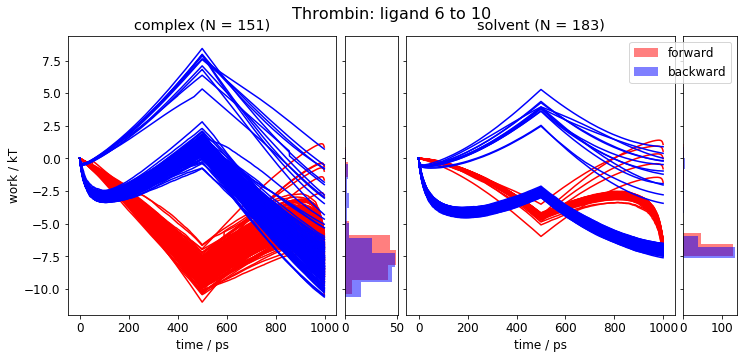

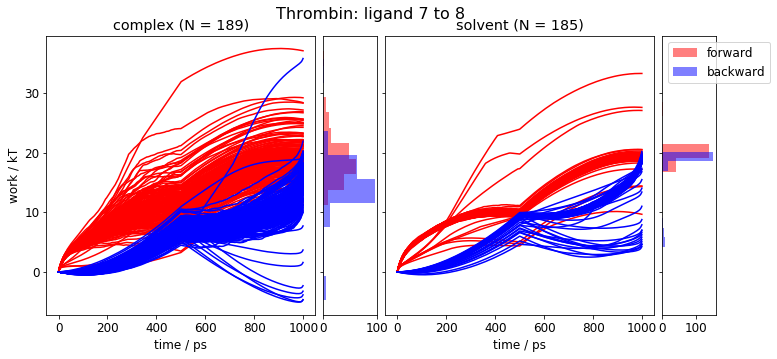

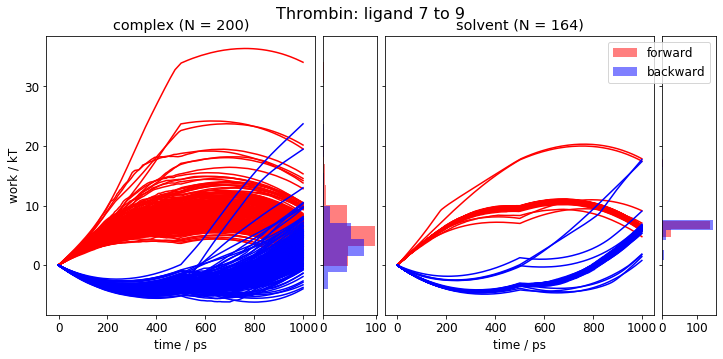

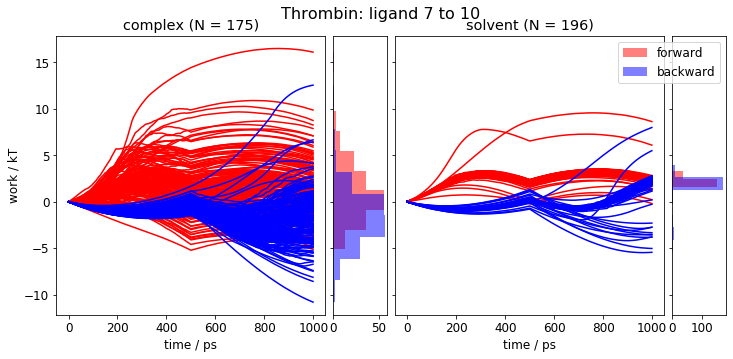

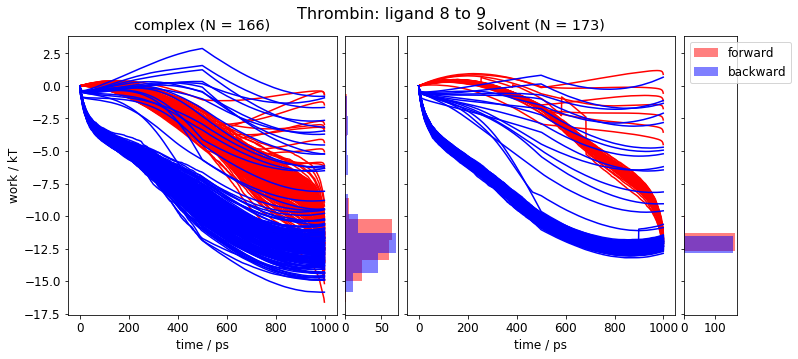

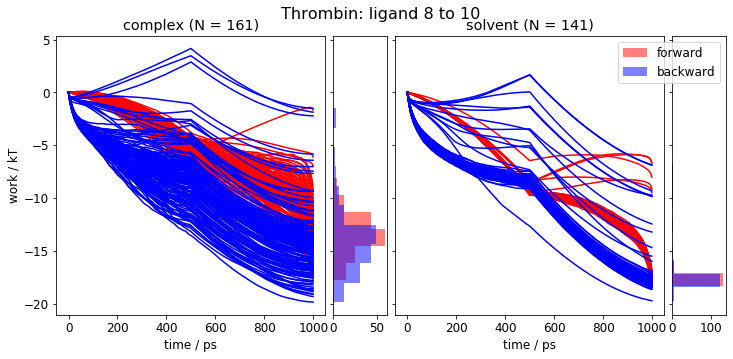

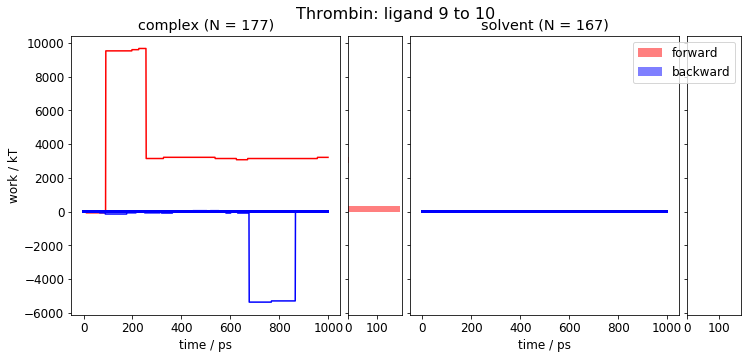

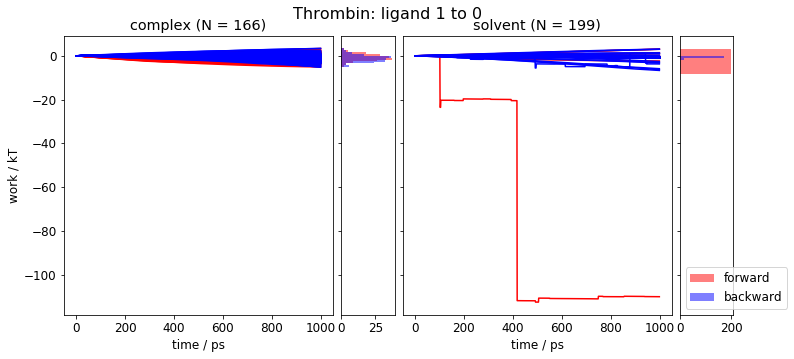

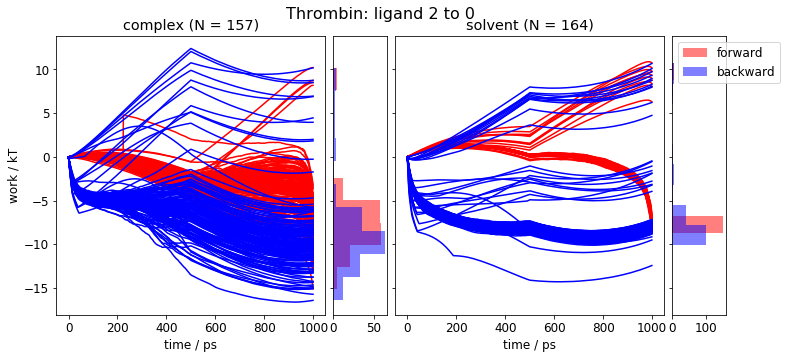

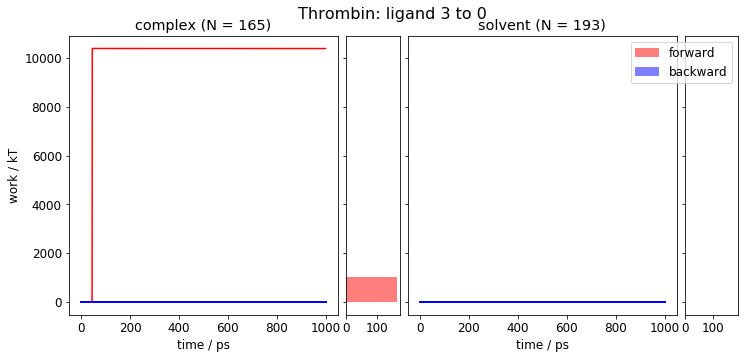

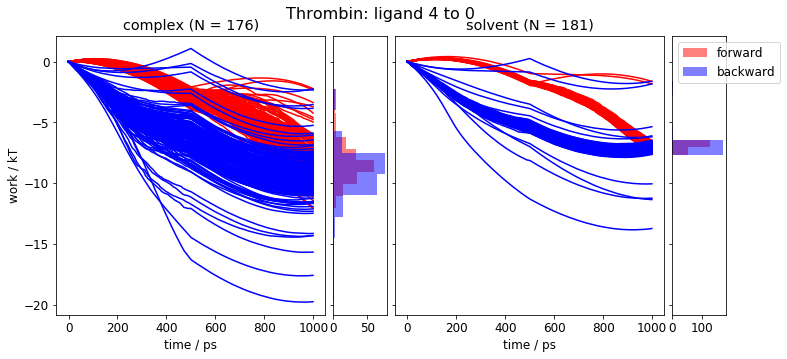

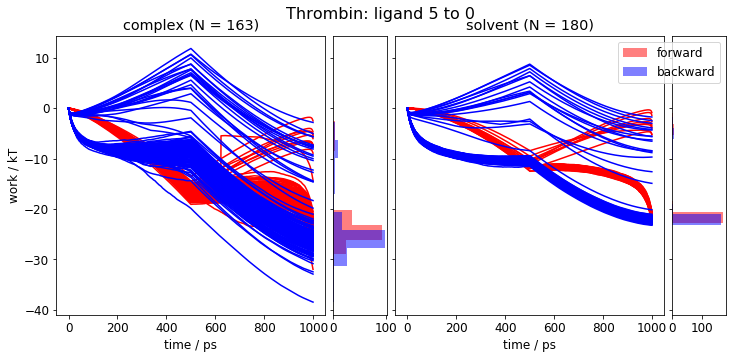

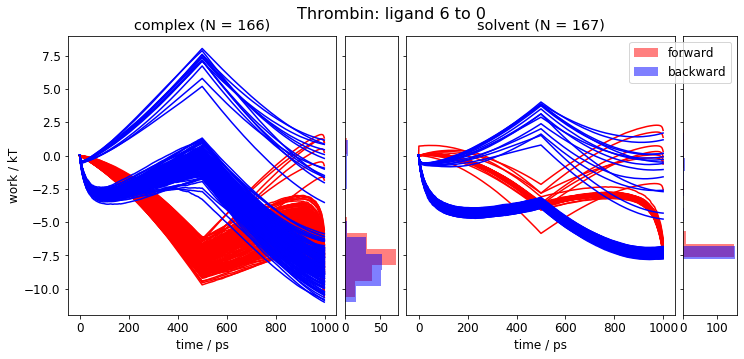

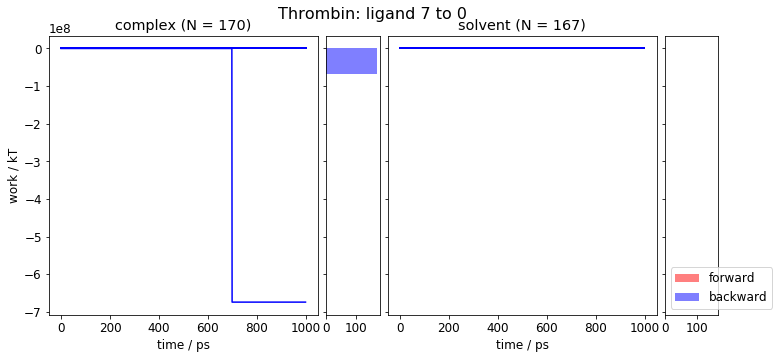

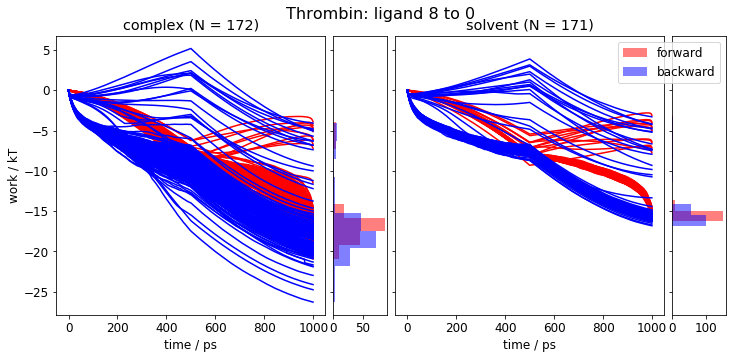

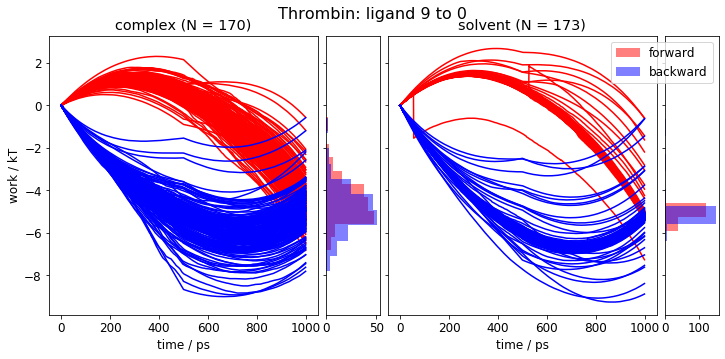

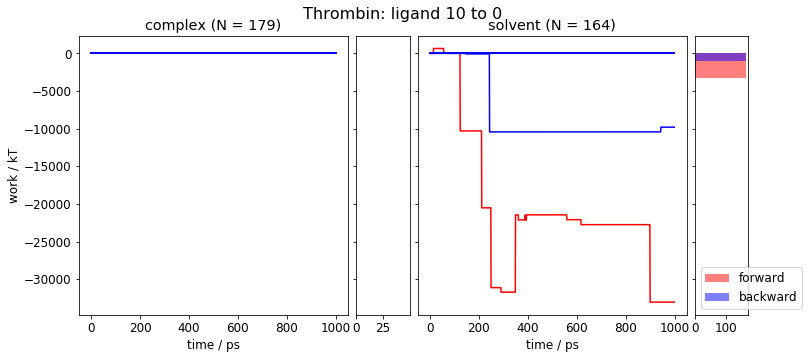

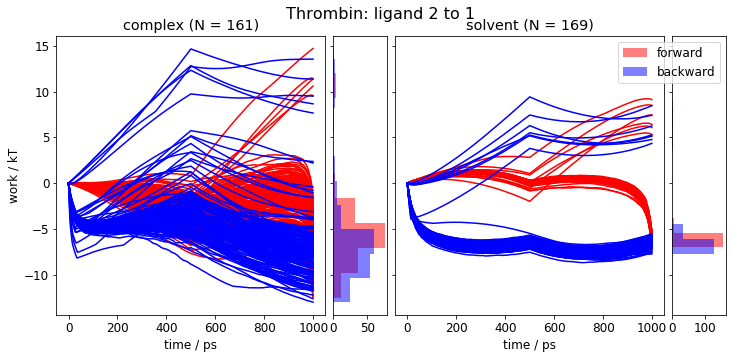

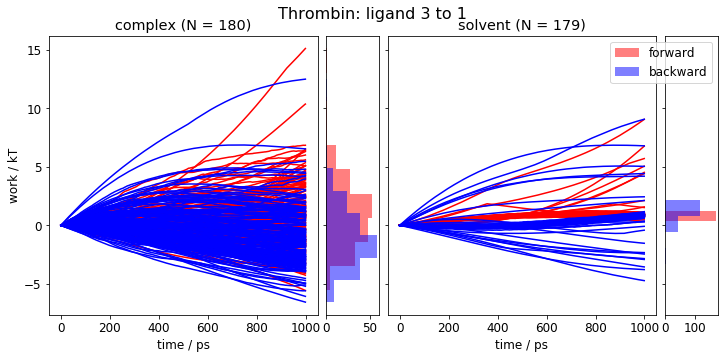

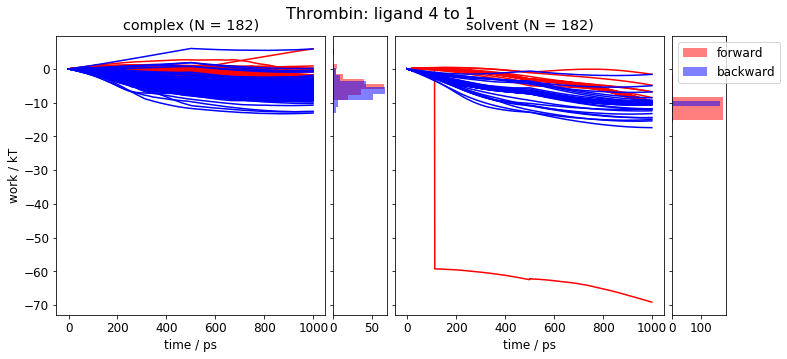

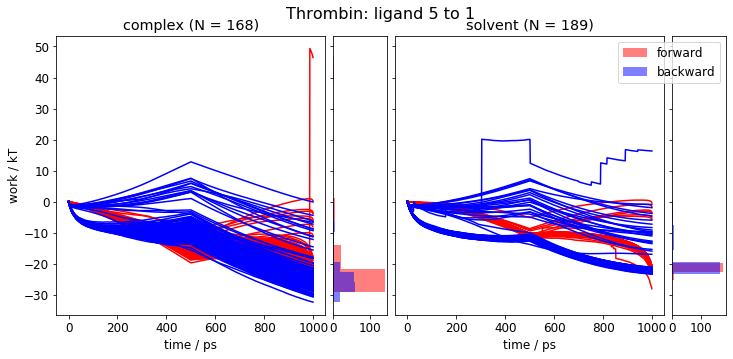

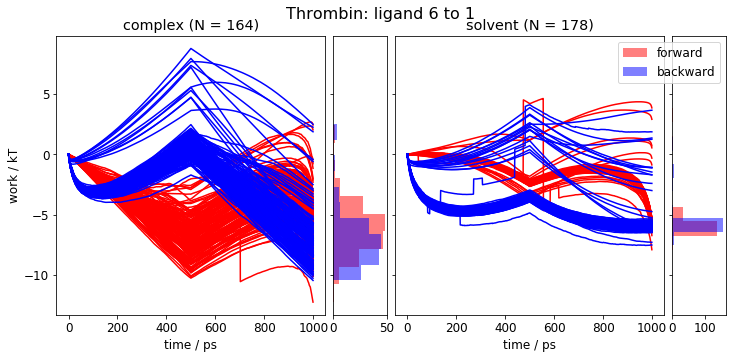

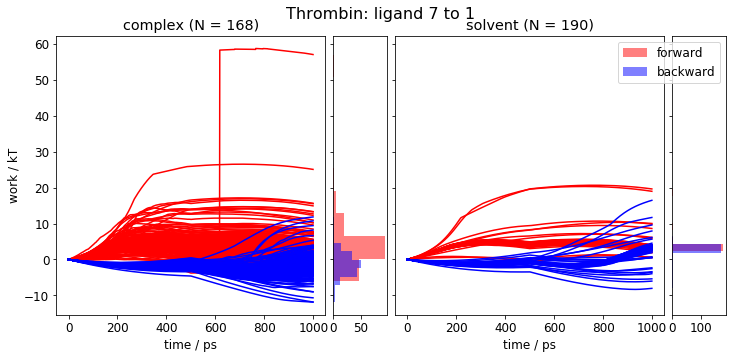

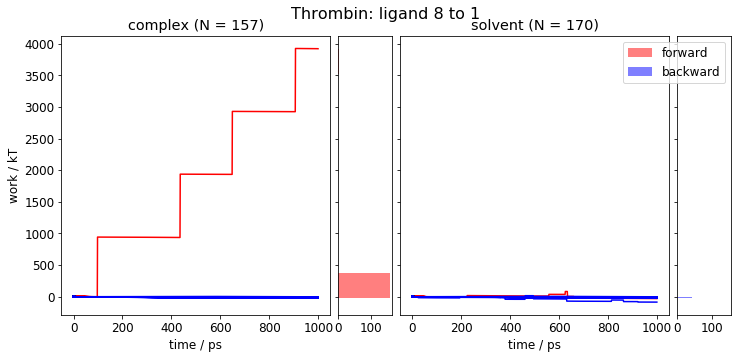

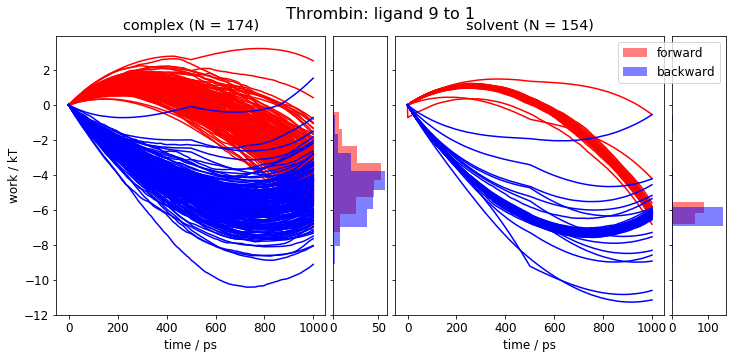

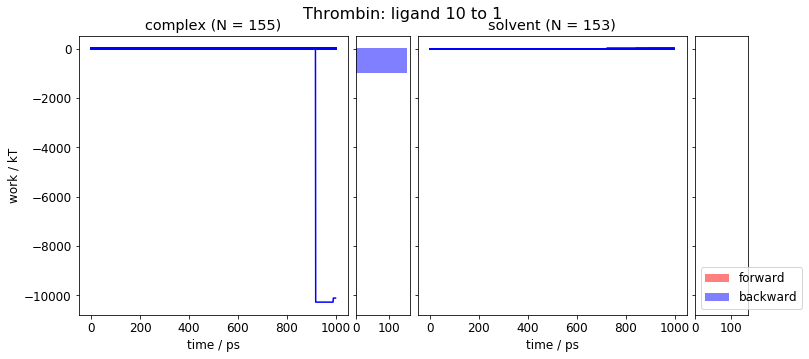

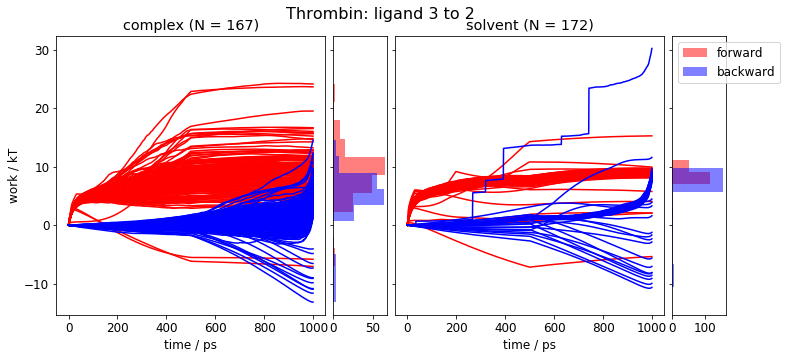

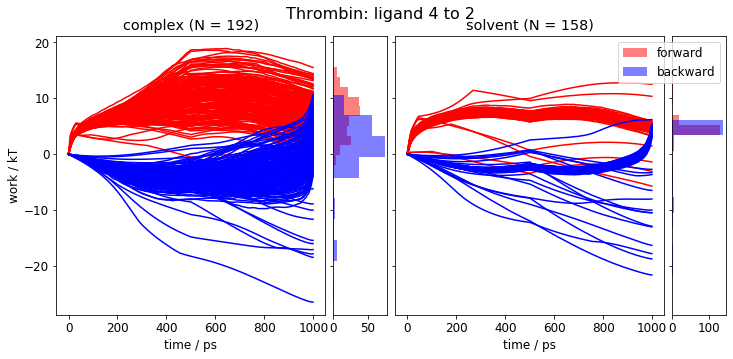

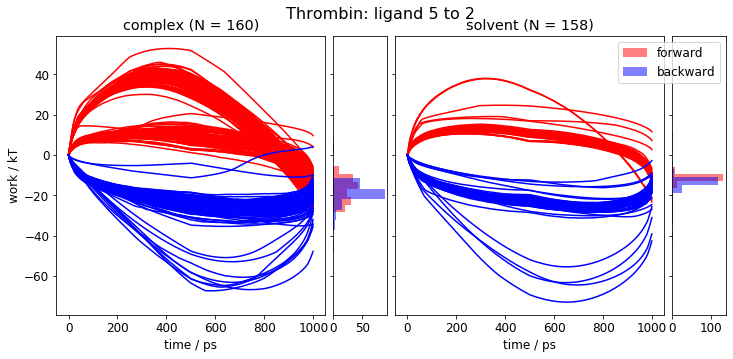

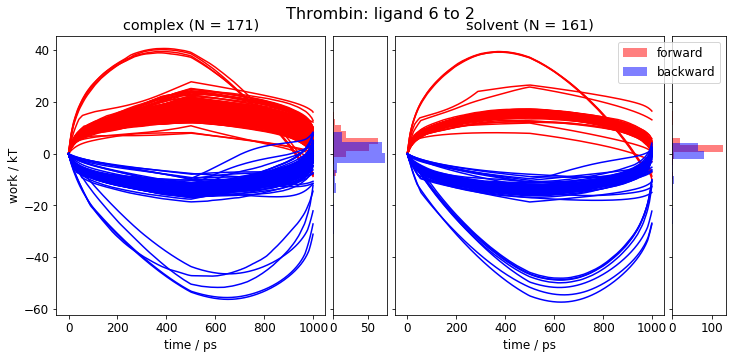

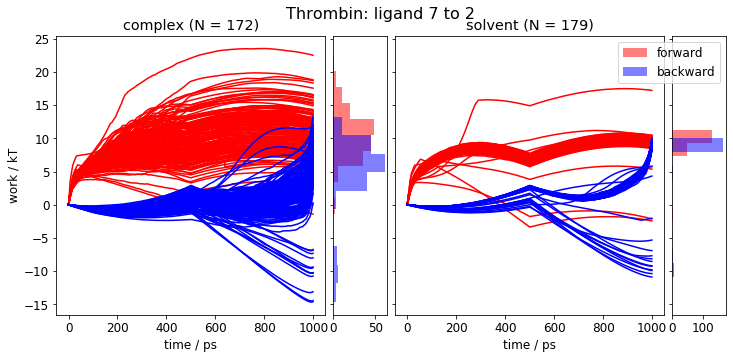

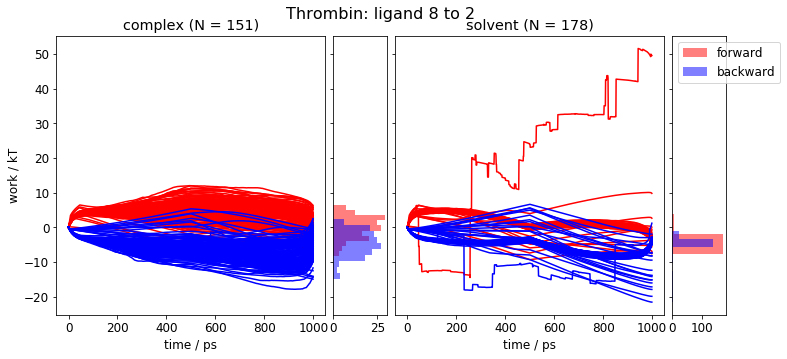

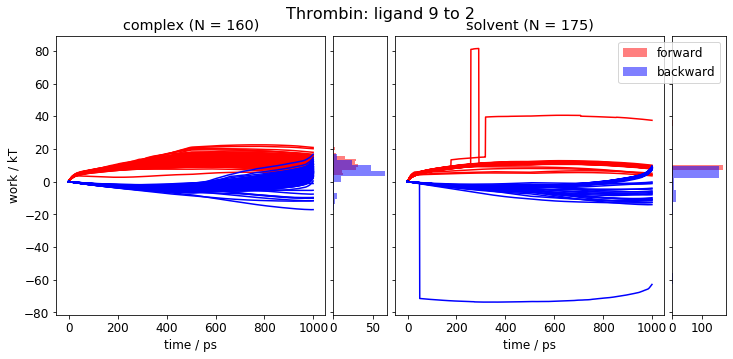

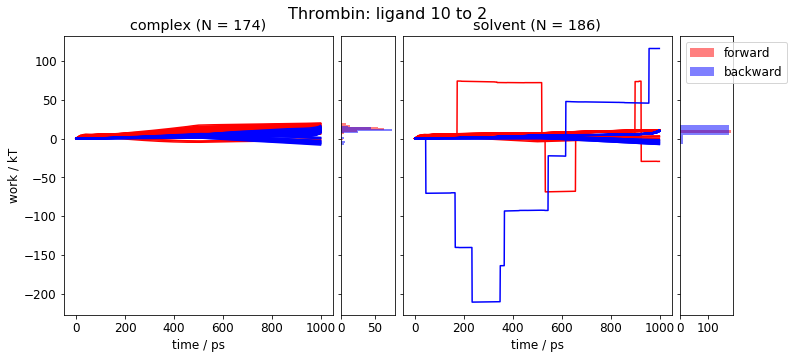

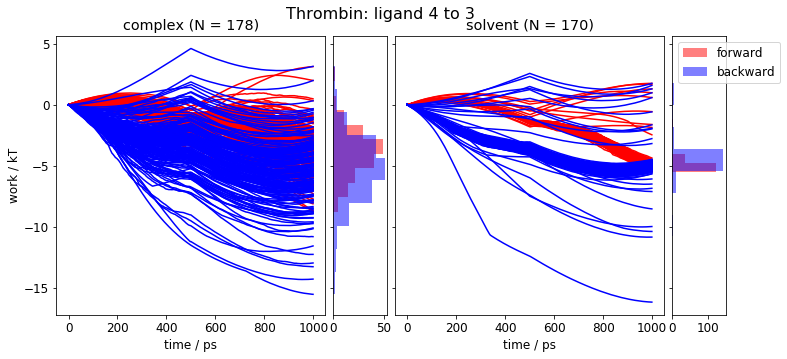

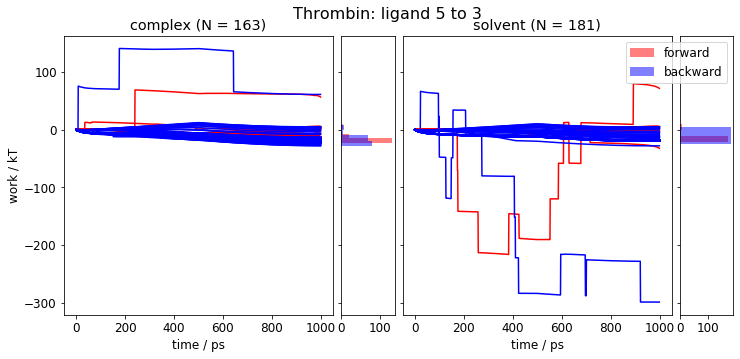

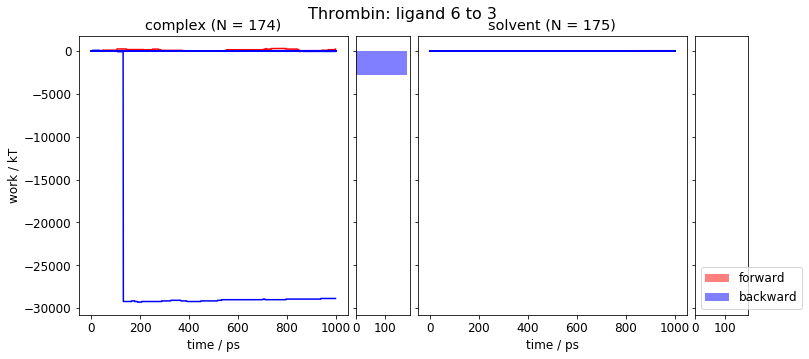

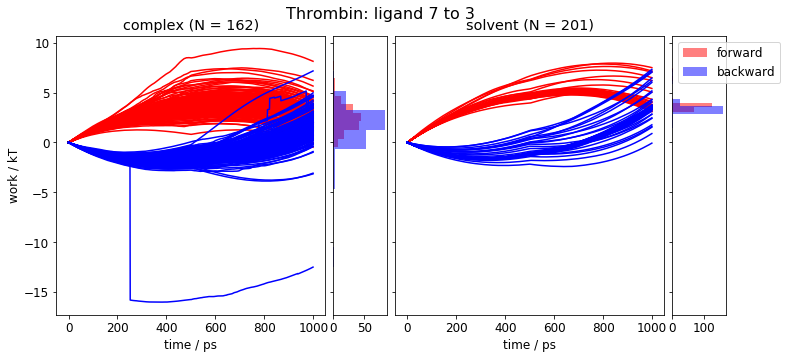

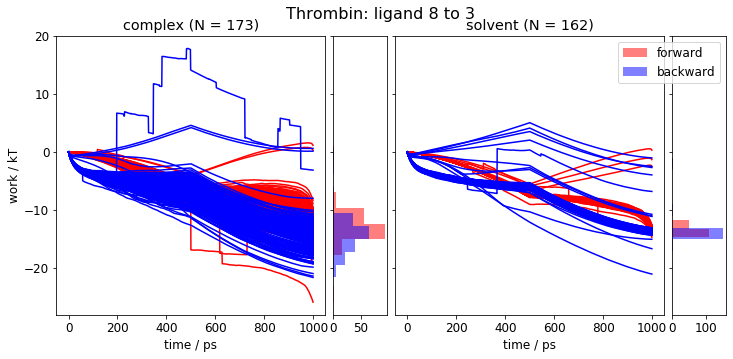

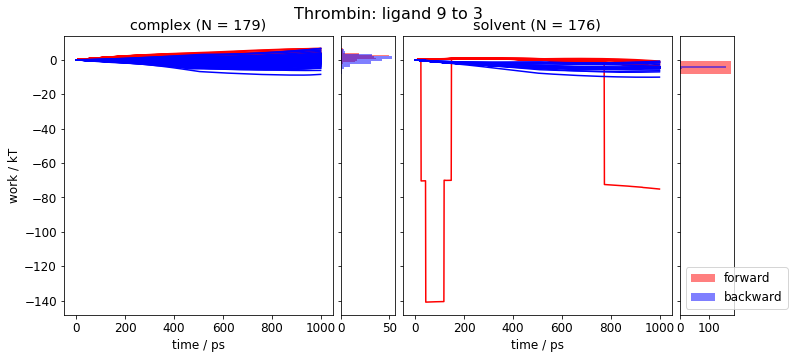

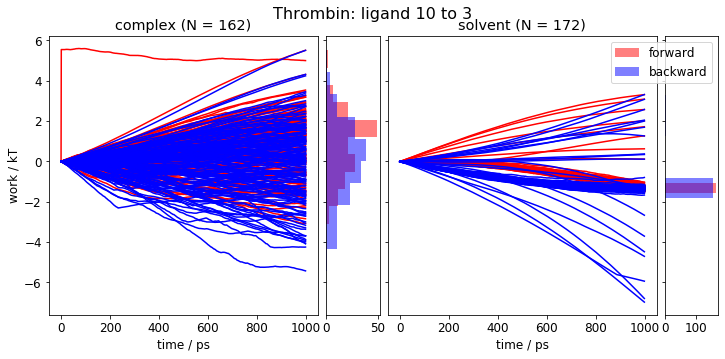

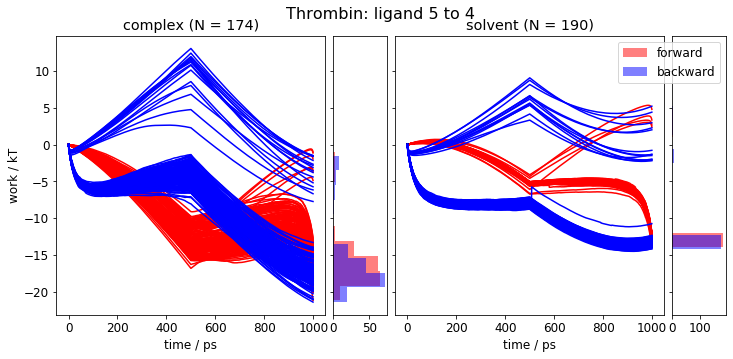

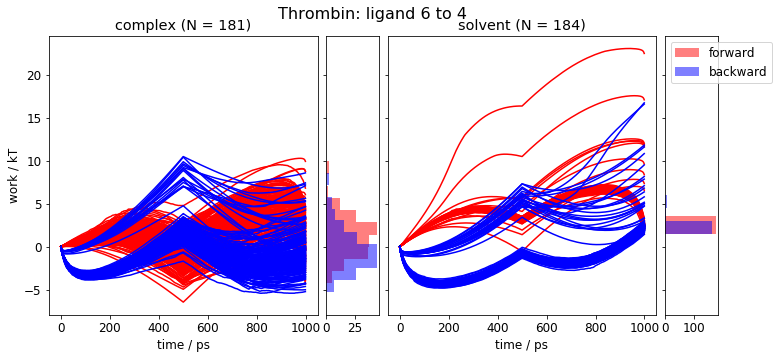

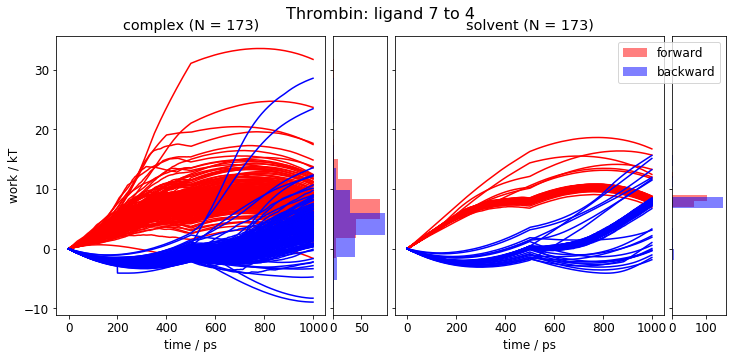

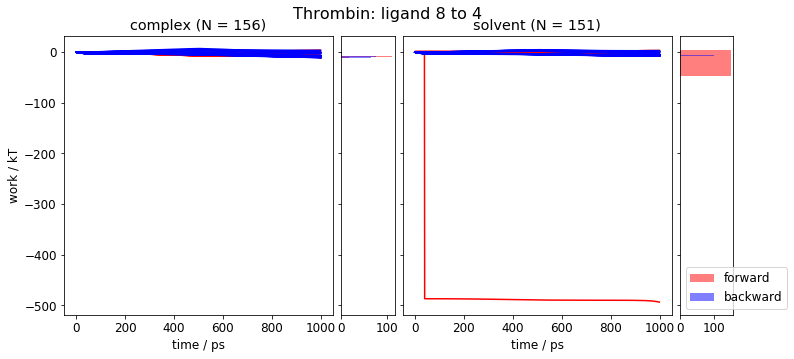

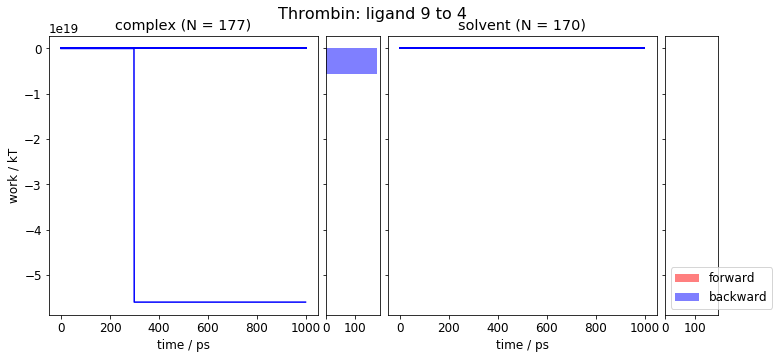

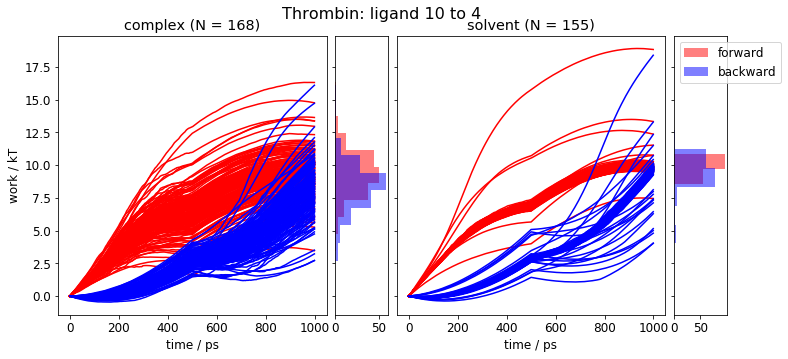

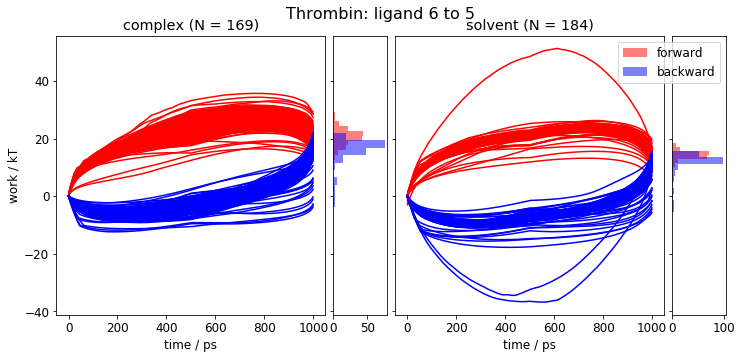

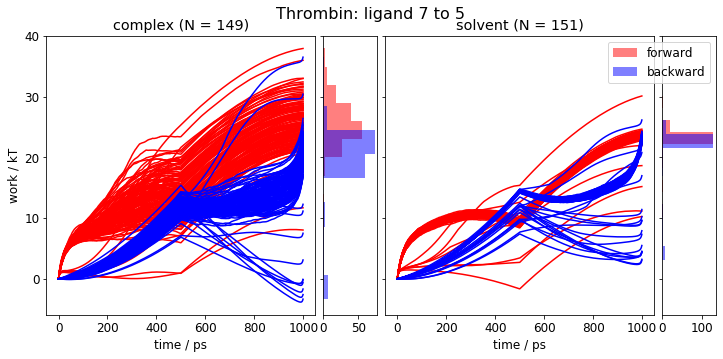

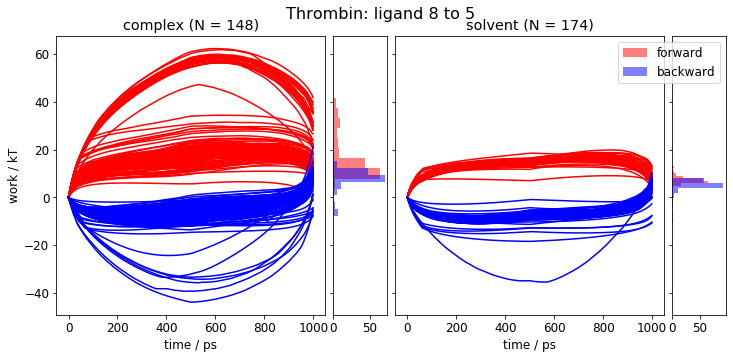

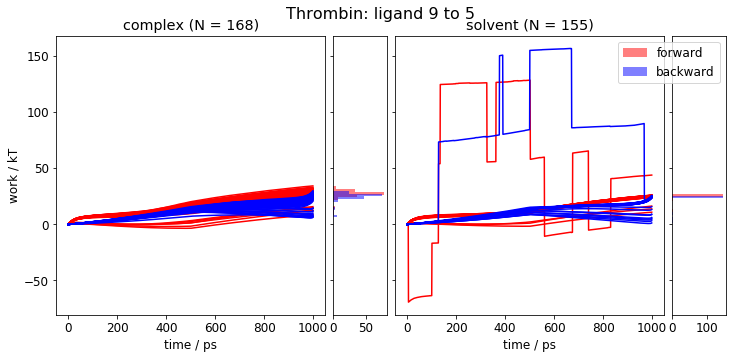

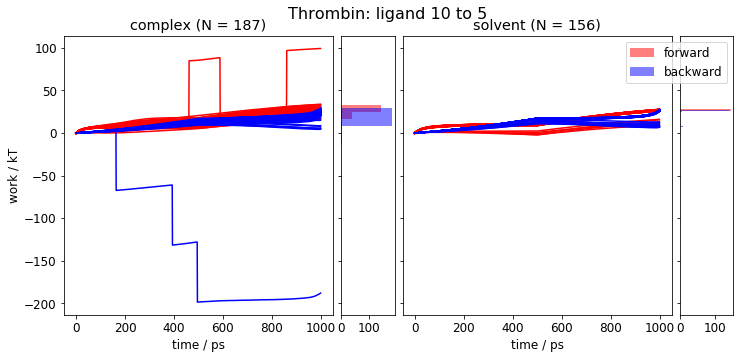

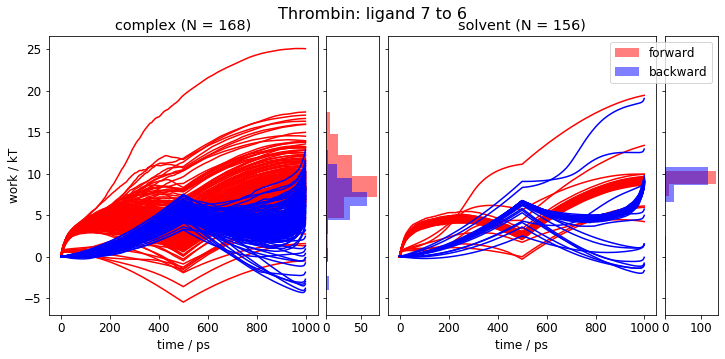

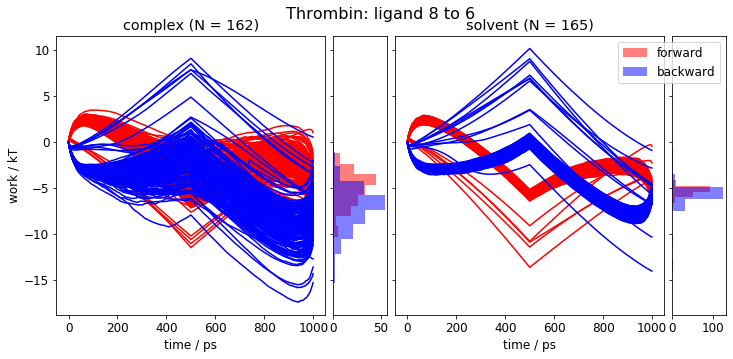

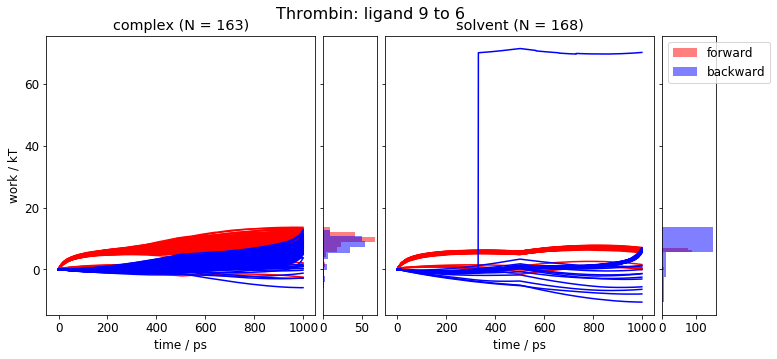

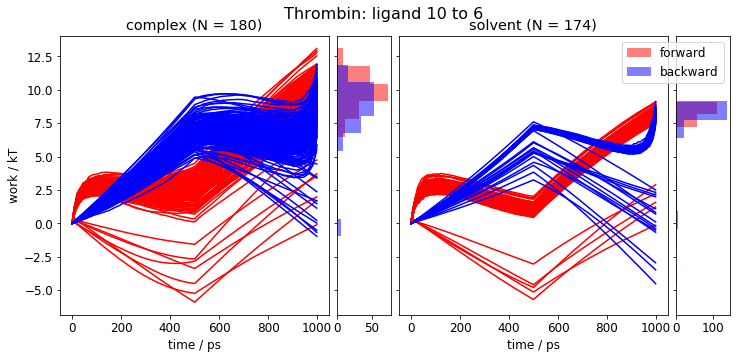

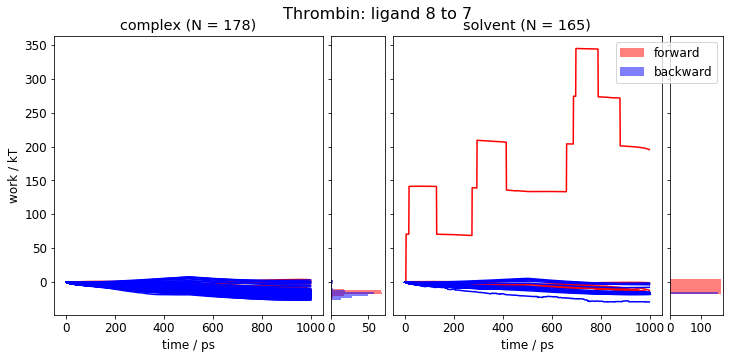

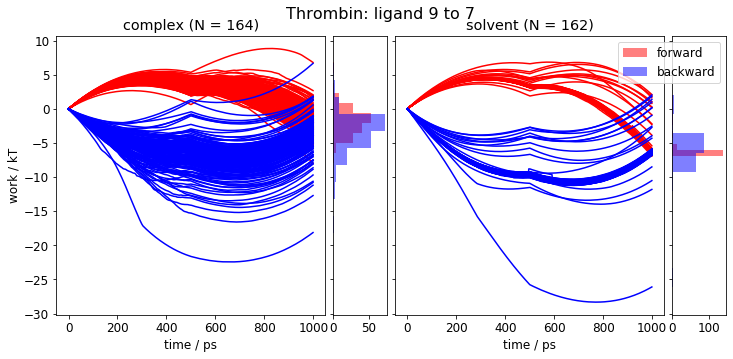

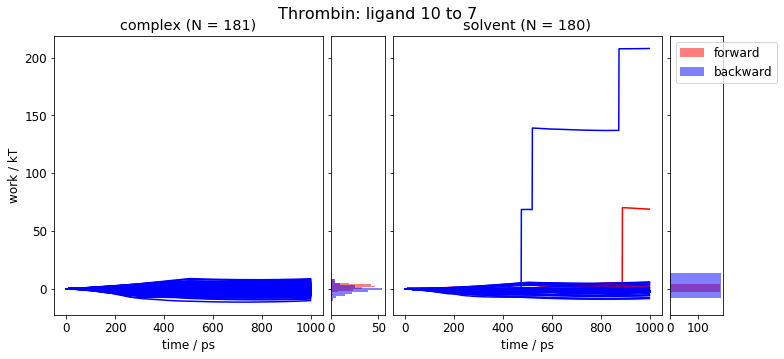

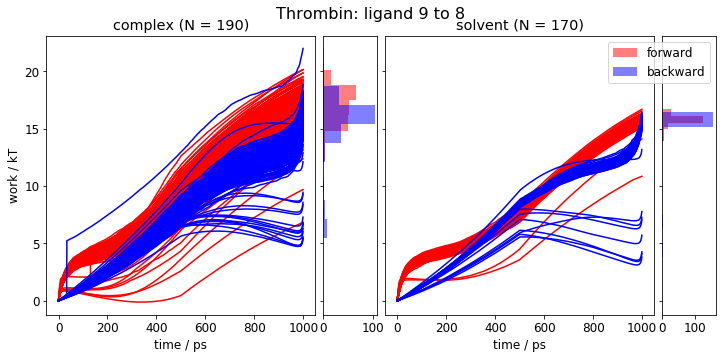

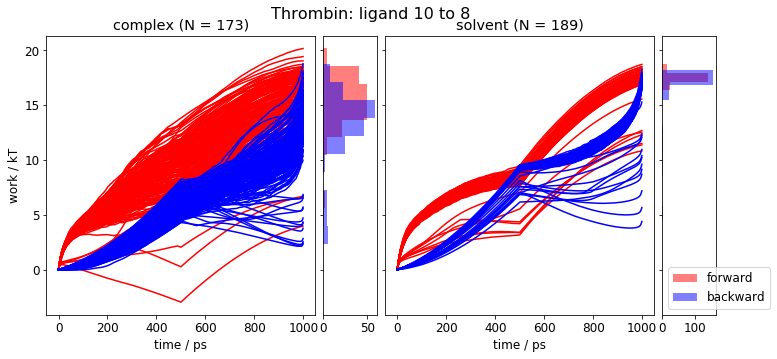

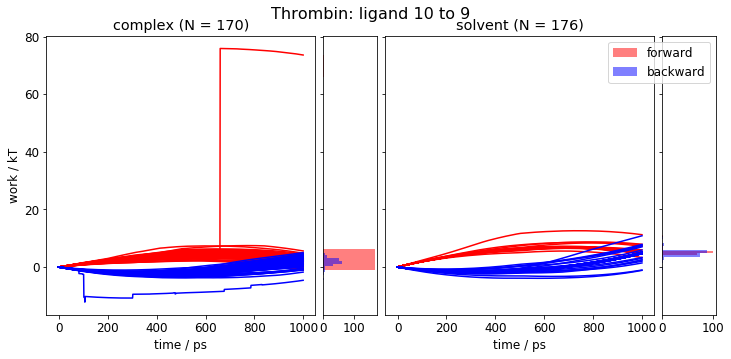

In [56]:
# TODO sort so that forwards and backwards are next to eachother
for index in range(0,110): # Just thrombin for now
    RUN = f'RUN{index}'
    if RUN in work[projects['complex']].keys() and RUN in work[projects['solvent']].keys():
        fig, axes = plt.subplots(ncols=4,nrows=1,sharey=True,figsize=(12,5),gridspec_kw={'width_ratios': [5,1,5,1]})

        forward_work_complex = list()
        reverse_work_complex = list()
        for CLONE in work[projects['complex']][RUN].keys():
            try:
                for GEN in work[projects['complex']][RUN][CLONE].keys():
                    protocol_work = work[projects['complex']][RUN][CLONE][GEN]
                    if len(protocol_work) != 4001:
                        continue
                    forward_work_complex.append(protocol_work[1000:2000] - protocol_work[1000])
                    reverse_work_complex.append(protocol_work[3000:4000] - protocol_work[3000])
            except Exception as e:
                pass

            forward_work = np.array(forward_work_complex)
        reverse_work = np.array(reverse_work_complex)
        complex_fe = BAR(forward_work[:,-1],reverse_work[:,-1])

        ax = axes[0]
        ax.plot(+forward_work.T, 'r-')    
        ax.plot(-reverse_work.T, 'b-')  
        ax.set_xlabel('time / ps')
        ax.set_ylabel('work / kT')
        ax.set_title(f'complex (N = {len(forward_work)})')

        hist_plot = axes[1]
        # TODO make histograms prettier
        hist_plot.hist(forward_work[:,-1], orientation='horizontal',linewidth=3,color='r',alpha=0.5)    
        hist_plot.hist(-reverse_work[:,-1], orientation='horizontal',linewidth=3,color='b',alpha=0.5)    
        
        complex_fes = np.zeros(shape=(n_boots))
        n_samples = len(forward_work[:,-1])
        for i in range(n_boots):
            samples = np.random.choice(range(n_samples),n_samples)
            complex_fes[i] = BAR(forward_work[:,-1][samples],reverse_work[:,-1][samples])[0]
            
        forward_work_solvent = list()
        reverse_work_solvent = list()
        for CLONE in work[projects['solvent']][RUN]:
            try:
                for GEN in work[projects['solvent']][RUN][CLONE].keys():
                    protocol_work = work[projects['solvent']][RUN][CLONE][GEN]
                    if len(protocol_work) != 4001:
                        continue
                    forward_work_solvent.append(protocol_work[1000:2000] - protocol_work[1000])
                    reverse_work_solvent.append(protocol_work[3000:4000] - protocol_work[3000])
            except Exception as e:
                pass 

        forward_work = np.array(forward_work_solvent)
        reverse_work = np.array(reverse_work_solvent)

        solvent_fes = np.zeros(shape=(n_boots))
        n_samples = len(forward_work[:,-1])
        for i in range(n_boots):
            samples = np.random.choice(range(n_samples),n_samples)
            solvent_fes[i] = BAR(forward_work[:,-1][samples],reverse_work[:,-1][samples])[0]
        
        ax = axes[2]
        ax.plot(+forward_work.T, 'r-')    
        ax.plot(-reverse_work.T, 'b-')
        ax.set_xlabel('time / ps')
        ax.set_title(f'solvent (N = {len(forward_work)})')

        hist_plot = axes[3]
        hist_plot.hist(forward_work[:,-1], orientation='horizontal',linewidth=3,color='r',alpha=0.5)    
        hist_plot.hist(-reverse_work[:,-1], orientation='horizontal',linewidth=3,color='b',alpha=0.5)       

        plt.legend(['forward','backward'])
        d = details[RUN]    
        details[RUN]['complex_fes'] = complex_fes
        details[RUN]['solvent_fes'] = solvent_fes
        details[RUN]['calculated'] = np.mean(solvent_fes) - np.mean(complex_fes)
        details[RUN]['calculated_err'] = (np.std(solvent_fes)**2 + np.std(complex_fes)**2)**0.5
        fig.suptitle(f"{d['protein_pdb'].split('_')[0]}: ligand {d['start_ligand']} to {d['end_ligand']}", fontsize=16)
        fig.subplots_adjust(top=0.9,wspace=0.05)
        plt.show()   

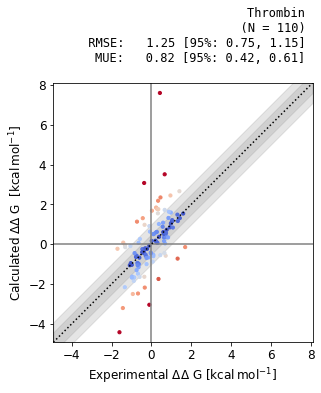

In [58]:
# make this less clunky
colors = {'Thrombin':'hotpink','Jnk1':'purple'}
graph_index = {'Thrombin':0,'Jnk1':1}


for t in ['Thrombin']:
    x = []
    y = []
    y_err = []
    for d in details.values():
        if len(d) == 8: # length will be 4 if calc is missing
            target = d['protein_pdb'].split('_')[0]
            if t != target:
                continue
            calc_kcal = (d['calculated']*kT).value_in_unit(unit.kilocalories_per_mole)
            calc_err_kcal = (d['calculated_err']*kT).value_in_unit(unit.kilocalories_per_mole)
            x.append(d['experimental'])
            y.append(calc_kcal)
            y_err.append(calc_err_kcal)
    plotting._master_plot(np.asarray(x),np.asarray(y),title=t)

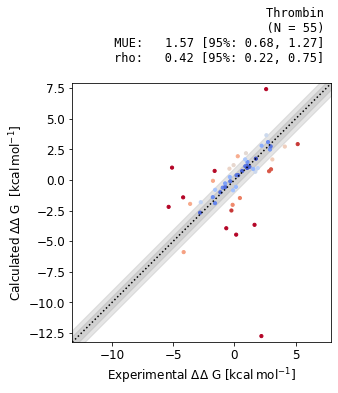

In [61]:
minimal = {}
for d in details.values():
    if len(d) == 8:
        target = d['protein_pdb'].split('_')[0]
        minimal[(target,d['start_ligand'],d['end_ligand'])] = d['calculated']

for target in ['Thrombin']:
    all_x = [minimal[t,i,j] for t,i,j in minimal.keys() if t == target and j < i and (t,j,i) in minimal.keys()]
    all_y = [-minimal[t,j,i] for t,i,j in minimal.keys() if t == target and j < i and (t,j,i) in minimal.keys()]
    plotting._master_plot(np.asarray(all_x),np.asarray(all_y),statistics=['MUE','rho'],origins=False,title=f'{target} binding i-j vs j-i')
    
    
# NEED TO ADD OPTION TO RELABEL X AND Y AXIS

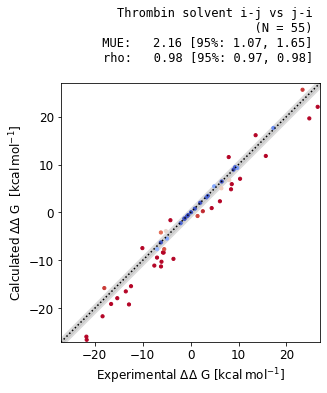

In [64]:
minimal = {}
for d in details.values():
    if len(d) == 8:
        target = d['protein_pdb'].split('_')[0]
        minimal[(target,d['start_ligand'],d['end_ligand'])] = np.mean(d['solvent_fes'])

for target in ['Thrombin']:
    all_x = [minimal[t,i,j] for t,i,j in minimal.keys() if t == target and j < i and (t,j,i) in minimal.keys()]
    all_y = [-minimal[t,j,i] for t,i,j in minimal.keys() if t == target and j < i and (t,j,i) in minimal.keys()]
    plotting._master_plot(np.asarray(all_x),np.asarray(all_y),statistics=['MUE','rho'],origins=False,title=f'{target} solvent i-j vs j-i')
    
    
# NEED TO ADD OPTION TO RELABEL X AND Y AXIS

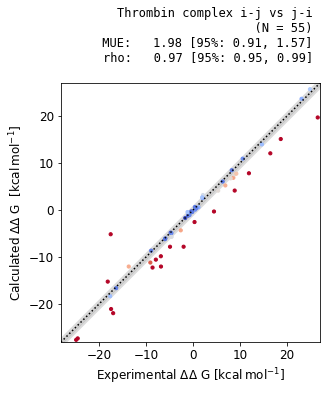

In [65]:
minimal = {}
for d in details.values():
    if len(d) == 8:
        target = d['protein_pdb'].split('_')[0]
        minimal[(target,d['start_ligand'],d['end_ligand'])] = np.mean(d['complex_fes'])

for target in ['Thrombin']:
    all_x = [minimal[t,i,j] for t,i,j in minimal.keys() if t == target and j < i and (t,j,i) in minimal.keys()]
    all_y = [-minimal[t,j,i] for t,i,j in minimal.keys() if t == target and j < i and (t,j,i) in minimal.keys()]
    plotting._master_plot(np.asarray(all_x),np.asarray(all_y),statistics=['MUE','rho'],origins=False,title=f'{target} complex i-j vs j-i')
    
    
# NEED TO ADD OPTION TO RELABEL X AND Y AXIS

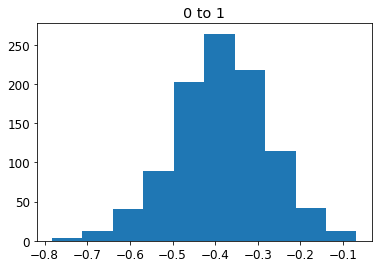

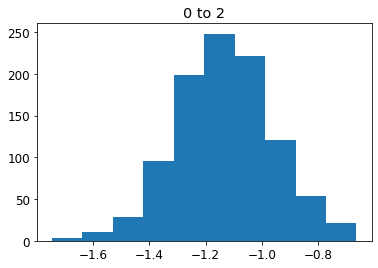

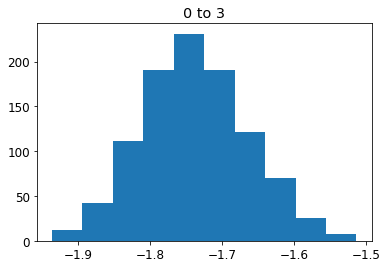

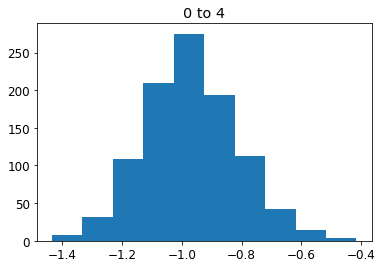

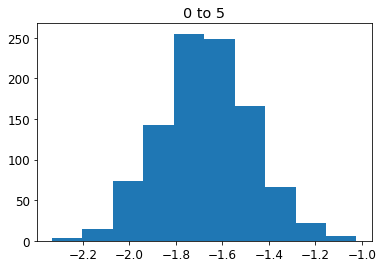

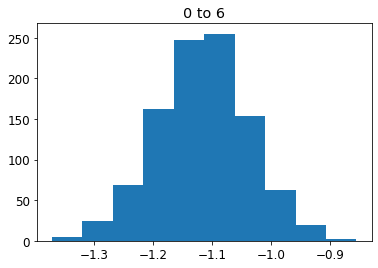

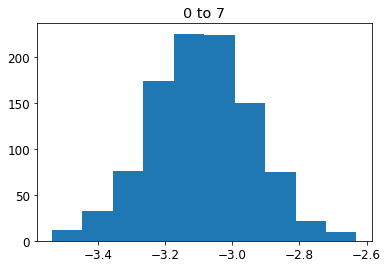

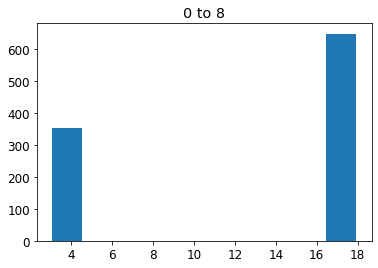

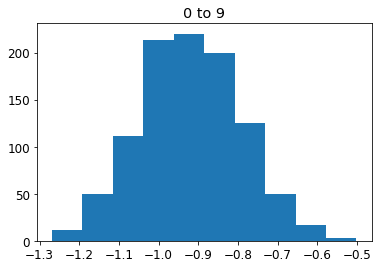

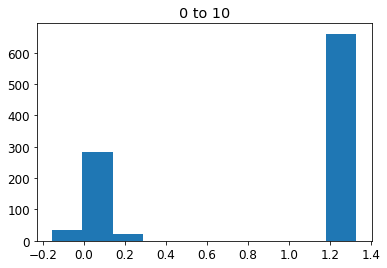

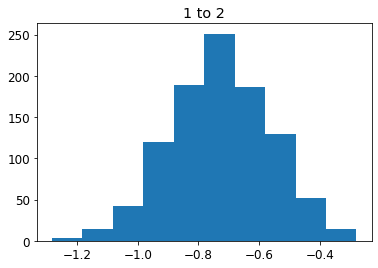

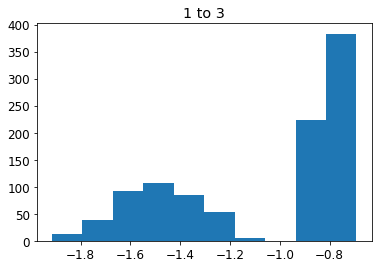

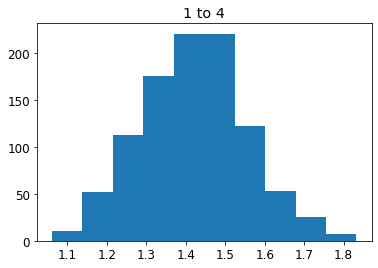

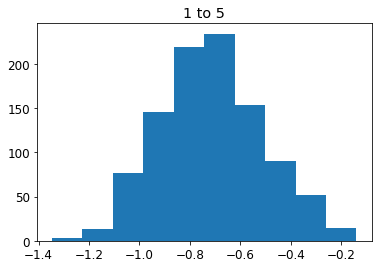

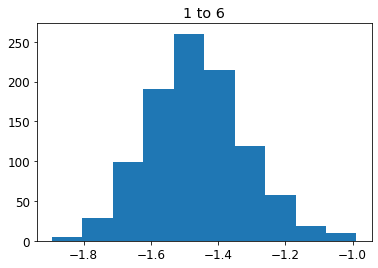

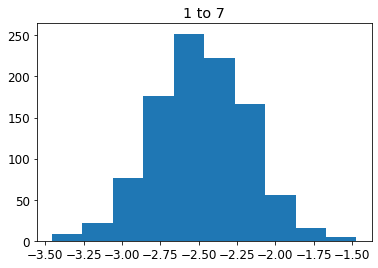

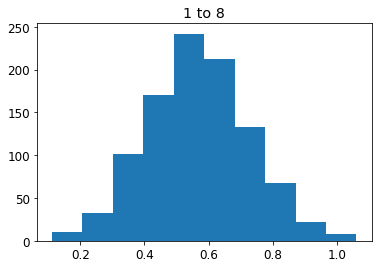

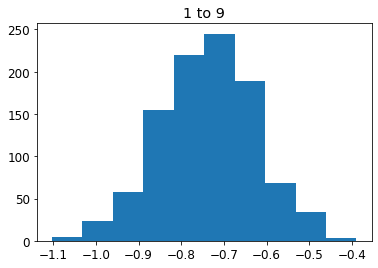

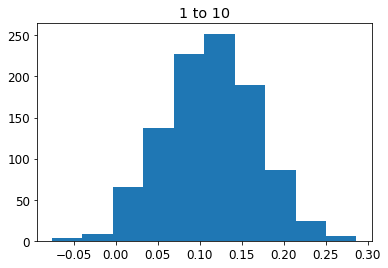

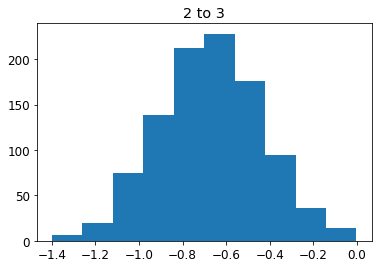

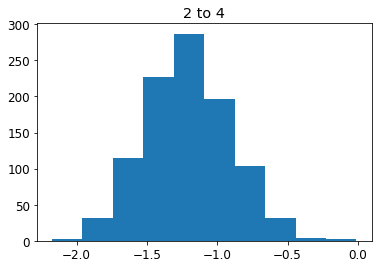

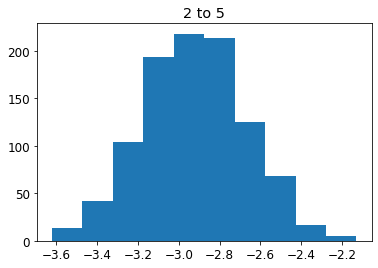

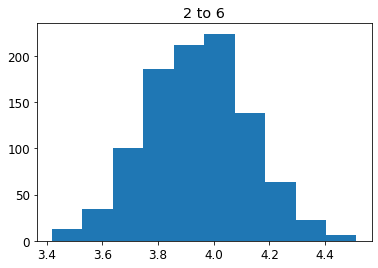

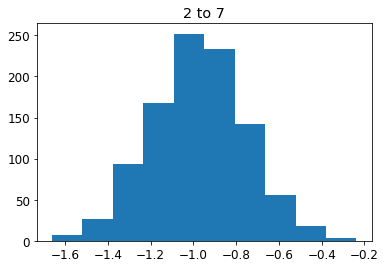

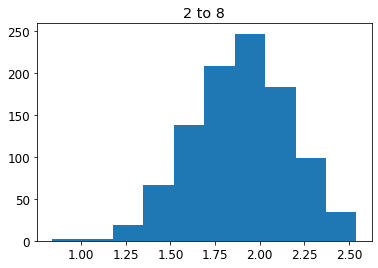

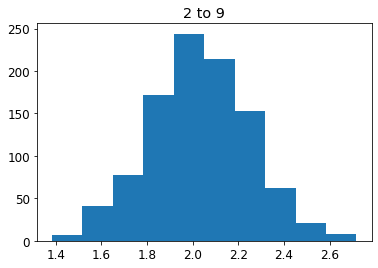

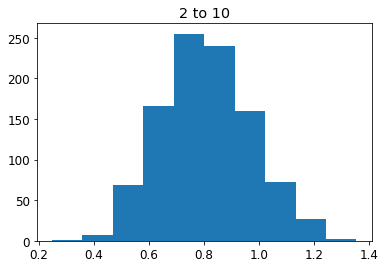

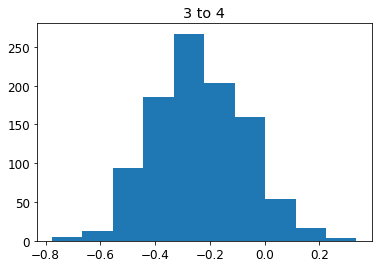

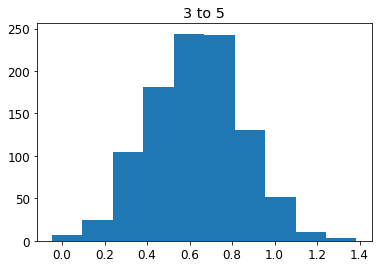

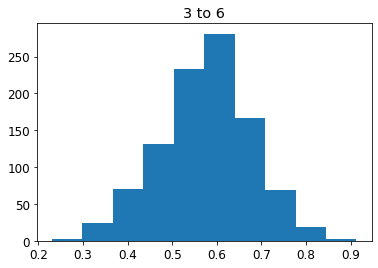

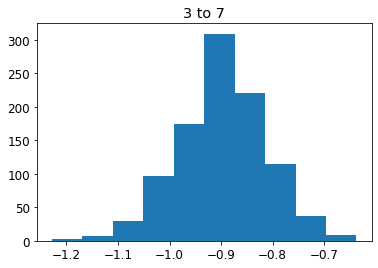

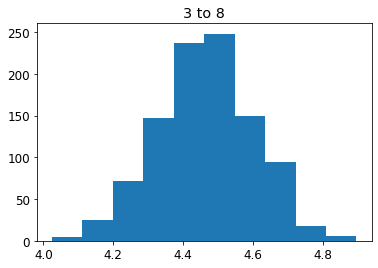

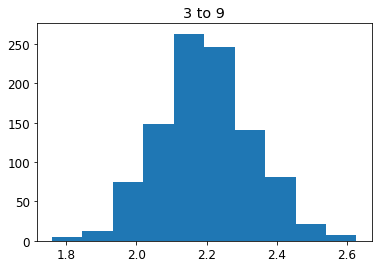

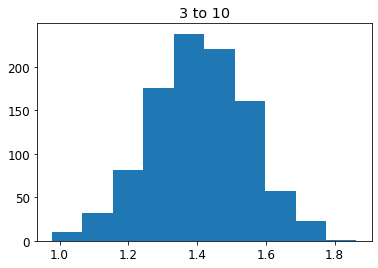

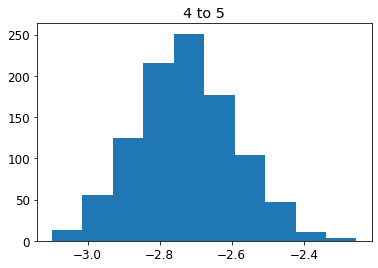

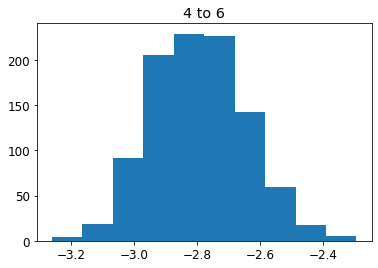

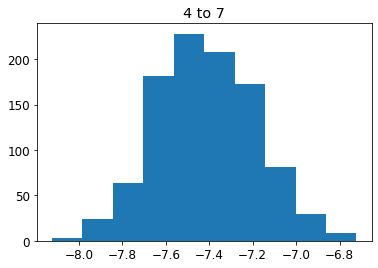

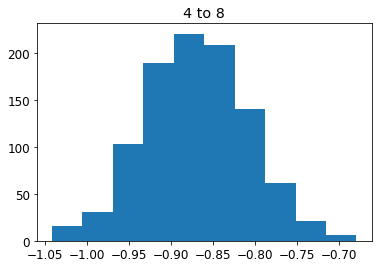

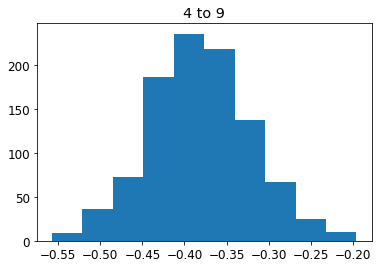

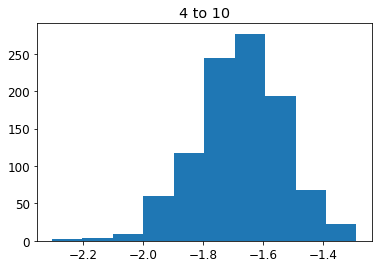

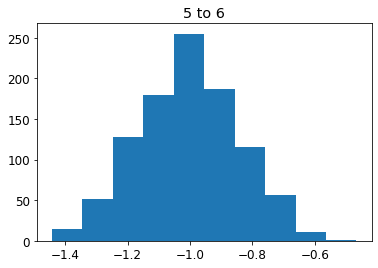

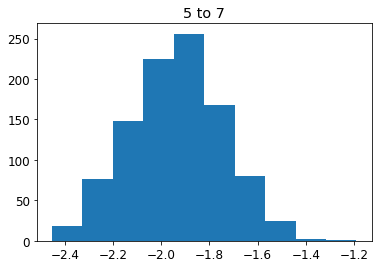

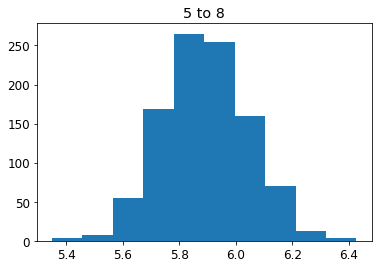

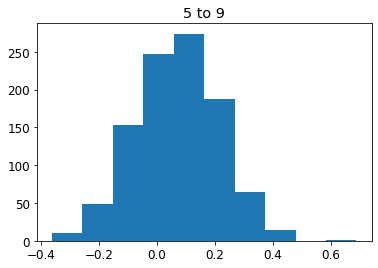

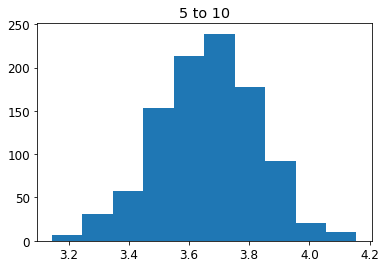

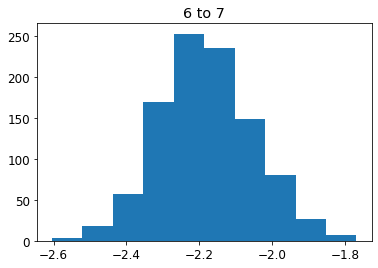

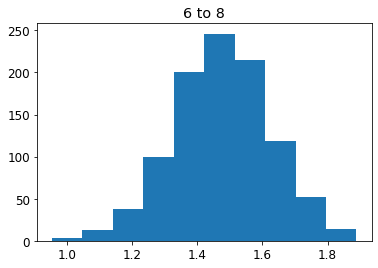

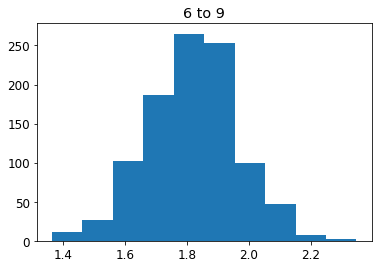

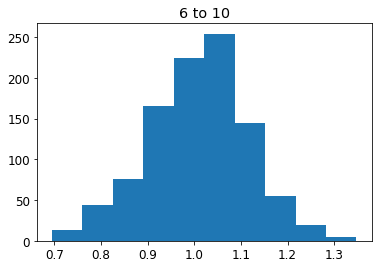

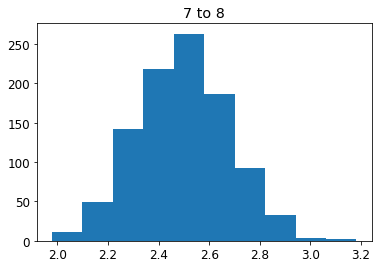

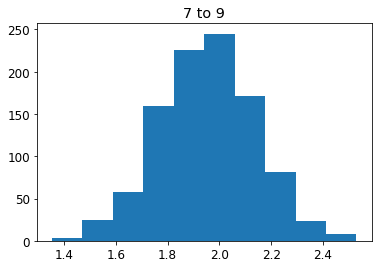

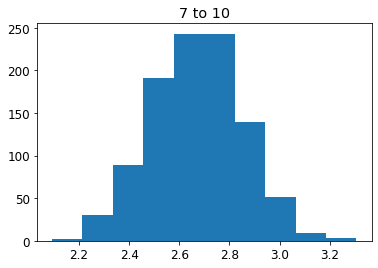

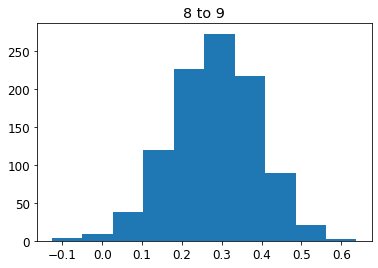

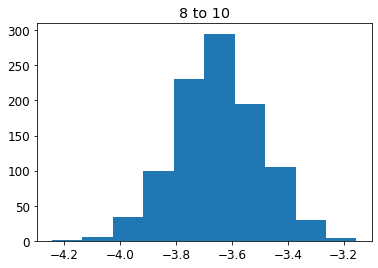

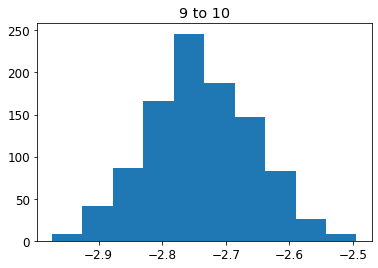

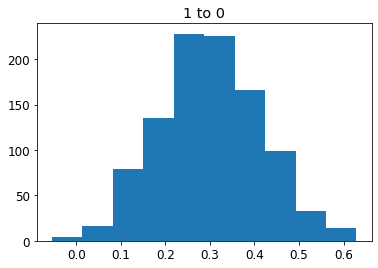

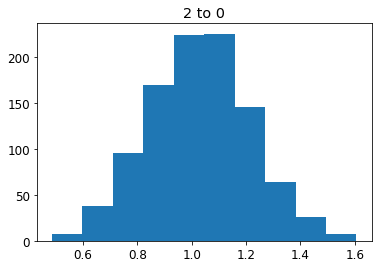

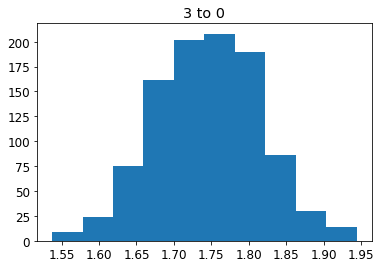

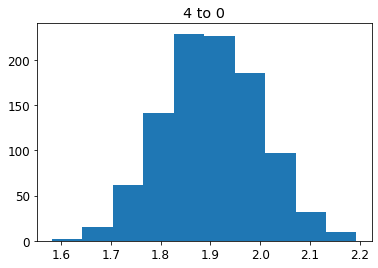

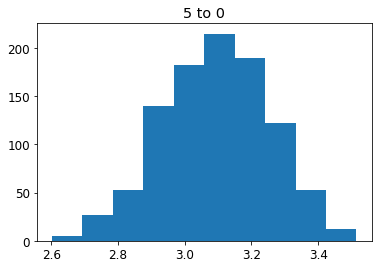

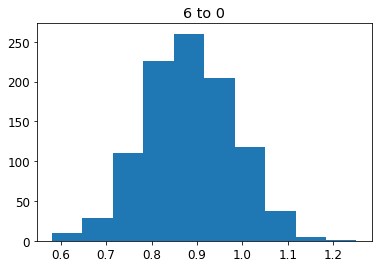

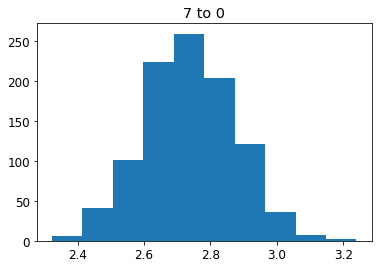

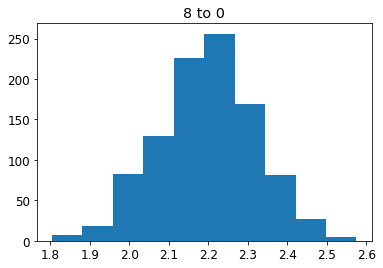

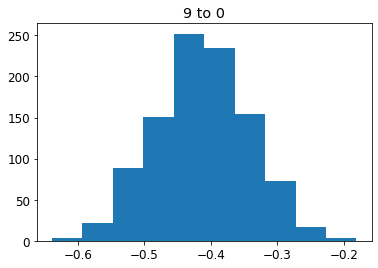

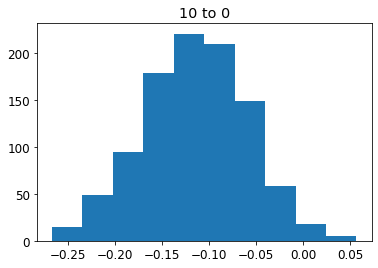

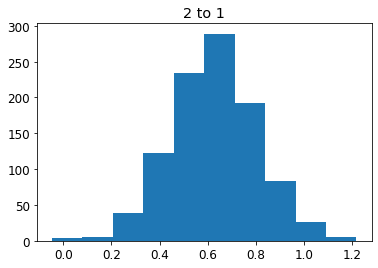

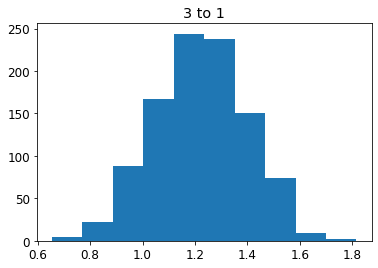

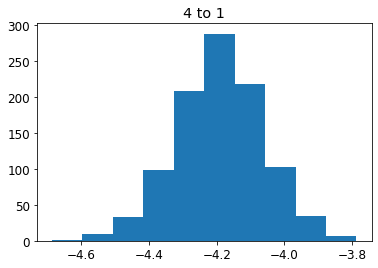

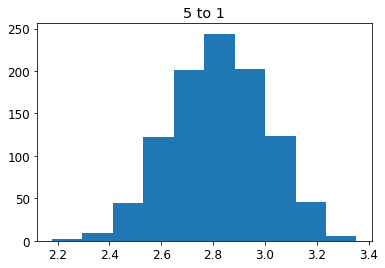

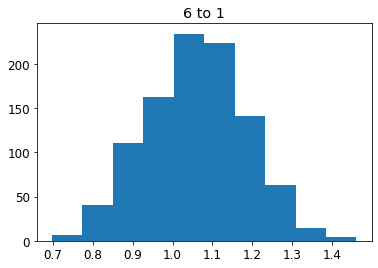

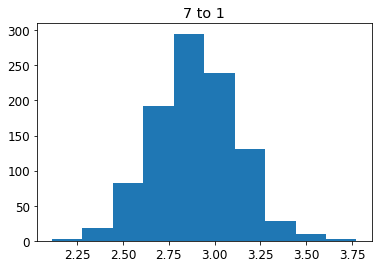

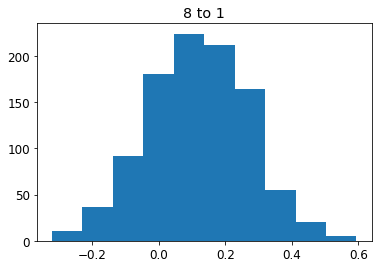

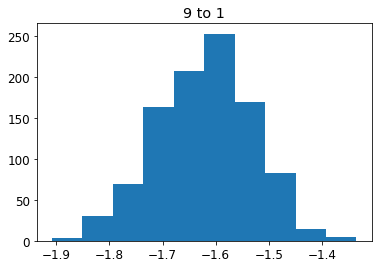

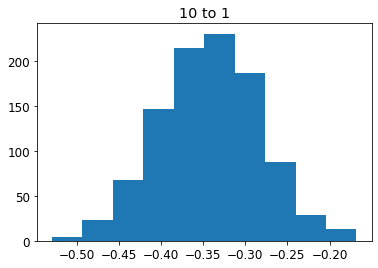

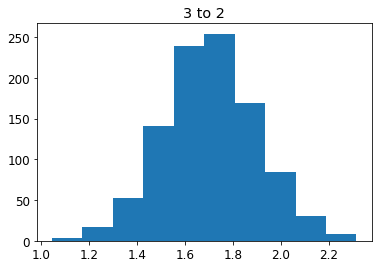

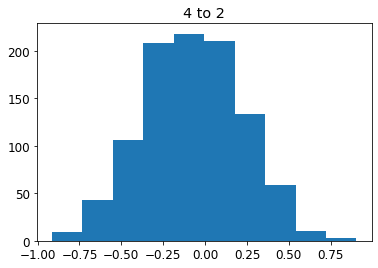

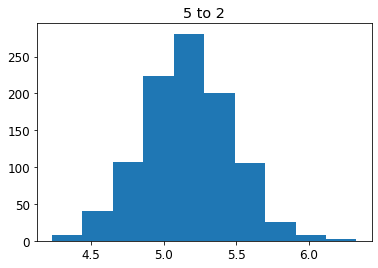

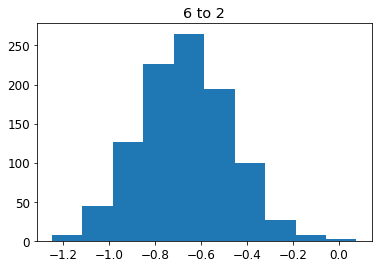

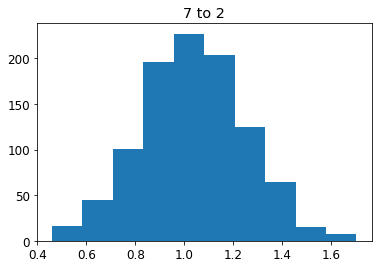

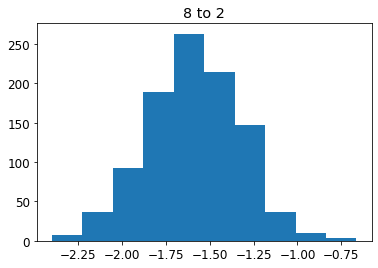

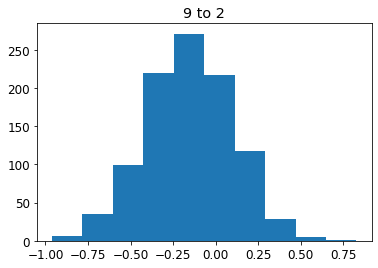

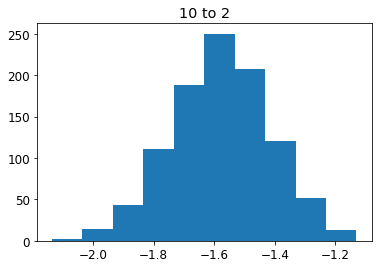

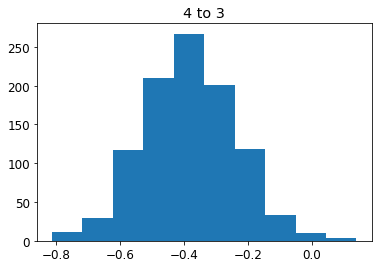

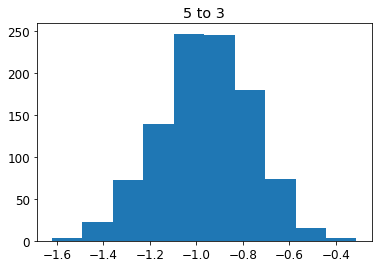

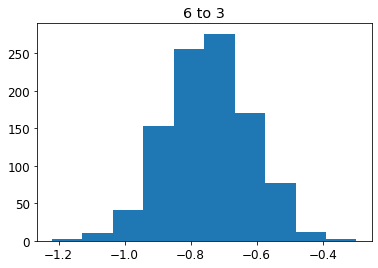

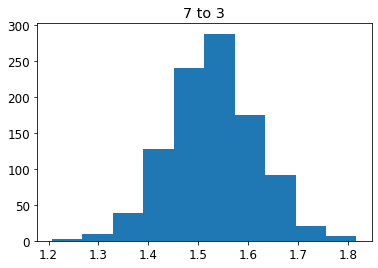

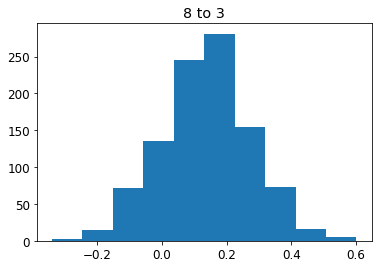

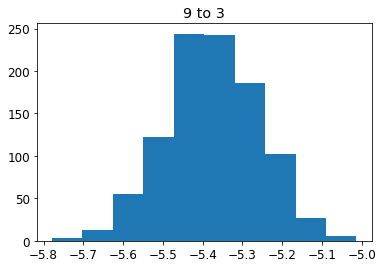

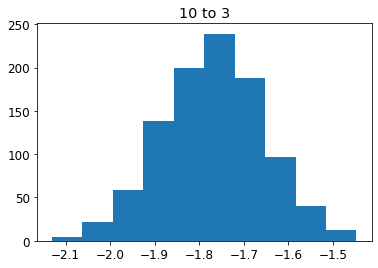

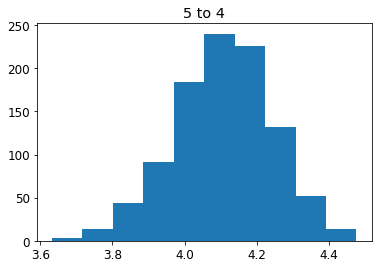

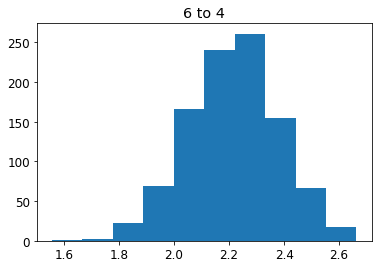

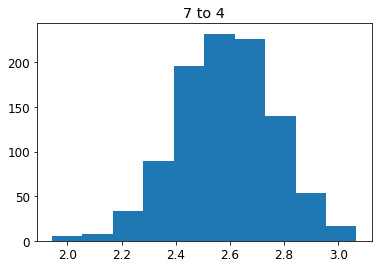

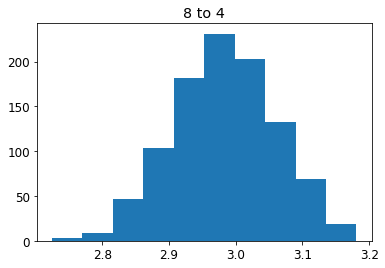

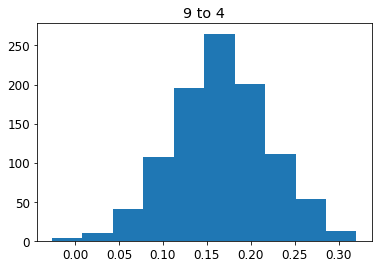

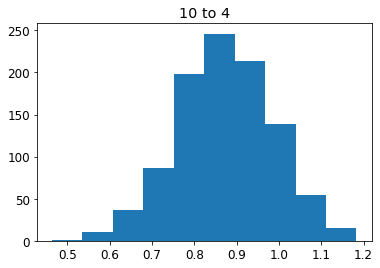

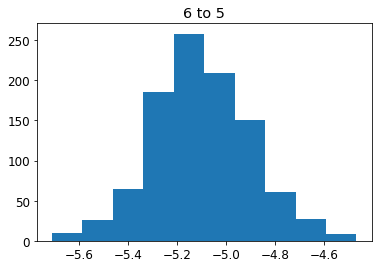

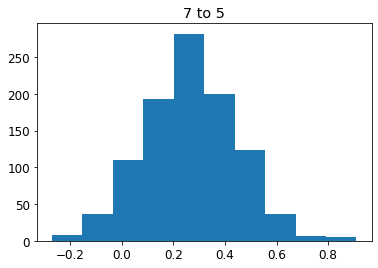

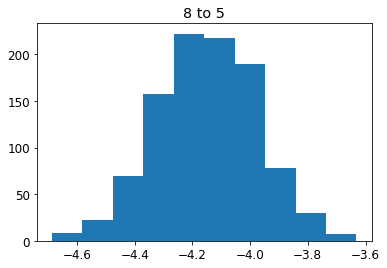

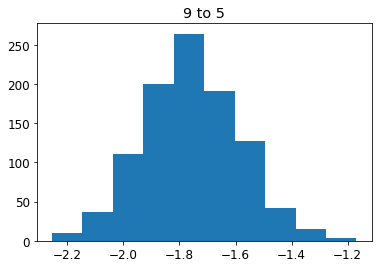

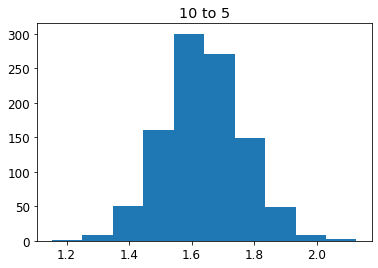

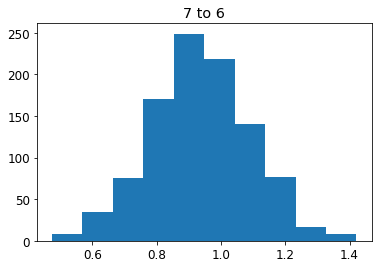

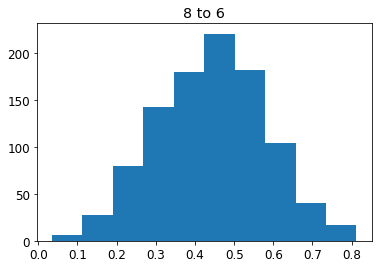

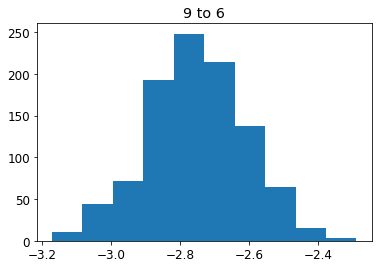

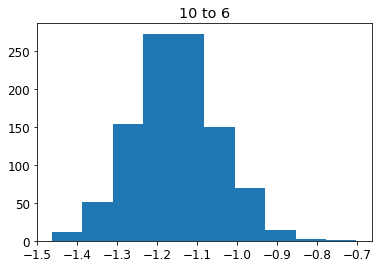

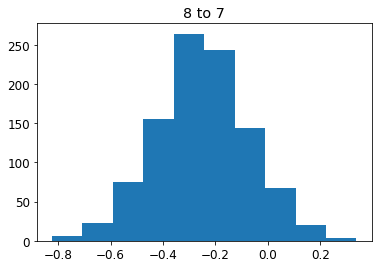

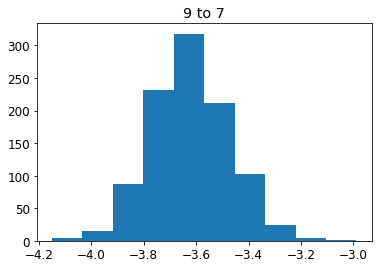

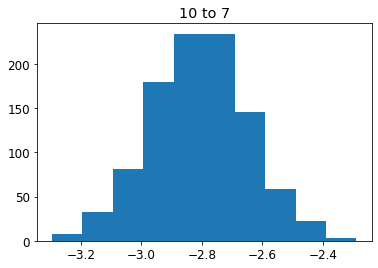

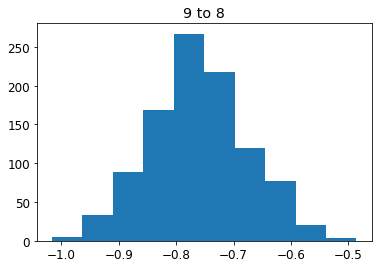

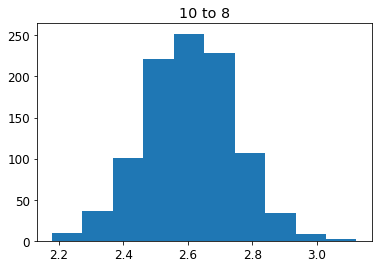

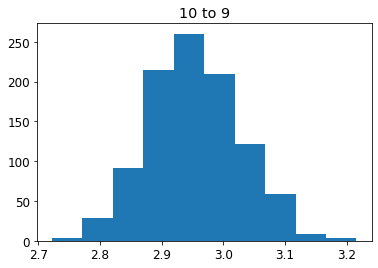

In [72]:
for d in details.values():
    if len(d) == 8:
        plt.hist(d['solvent_fes'] - d['complex_fes'])
        plt.title(f"{d['start_ligand']} to {d['end_ligand']}")
        plt.show()